In [39]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord


In [2]:
imageDirectory = '/data/mj1e16/kepler/cal/'
medianDir = '/data/mj1e16/kepler/newDiff/'

# imageDirectory = '/media/mj1e16/PP AV-TV/keplerCal/'
# medianDir = '/media/mj1e16/PP AV-TV/medians/'

In [3]:
dirlist = os.listdir(imageDirectory)
dirlist = [x for x in dirlist if x[0] != '.']
imagelist = [imageDirectory+x for x in dirlist]

In [4]:
def correctExtensionOrder(imageName):
    hdu_list = fits.open(imageName)
    extensionOrder = np.zeros(len(hdu_list))
    for channel in range(1,len(hdu_list)):
        hdr = hdu_list[channel].header
        location = hdr['SKYGROUP'] # independant location
        extensionOrder[location] = channel # ordered from 0-84 channel with extension in place of name
    return extensionOrder

In [5]:
extensionOrders = []
for image in imagelist:
    extensionOrders.append(correctExtensionOrder(image))

In [6]:
def getAllccds(imagelist,pos,extensionOrders):
    names = []
    for x in range(len(imagelist)):
        extension = int(extensionOrders[x][pos])
        names.append(imagelist[x]+'[{}]'.format(extension))
    return names

In [7]:
def getIndiExt(image,imagelist,extensionOrders,imDir=imageDirectory):
    loc1 = image.find('[')
    loc2  = image.find(']')
    imagename = imDir+image[:loc1]
    pos = image[loc1+1:loc2]
    imagepos = imagelist.index(imagename)
    #extensionOrders[imagepos] = extensionOrders[imagepos].tolist()
    XO = [str(int(x)) for x in extensionOrders[imagepos]]
    indiExt = XO.index(pos)
    return [indiExt,pos]

In [34]:
def findMatchesNoCondition(tab,ra,dec,max_sep = 2.5 * u.arcsec):
    
    df = tab.to_pandas()
    
    ra1 =[ra,ra]
    dec1 = [dec,dec]
    
    number2 = tab['OBJECT INDEX'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['OBJECT INDEX'].isin(objectsFound)]
    matchtab = Table.from_pandas(matchdf)
    return matchtab

In [9]:
def findDate(imageName,channel):
    hdu_list = fits.open(imageName)
    hdr = hdu_list[int(channel)].header
    date = hdr['MJDSTART'] # independant location
    return date

In [10]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [40]:
def makeLightCurves(origTab):
    allTabs = []
    imNames = []
    mag = []
    #date = []
    imageReDo = []
    fullExt = []
    otherfullExt = []
    for im in range(len(origTab)):
        ra = origTab['RA'][im]
        dec=origTab['DEC'][im]
        image = origTab['IMAGE_NAME'][im]
        indiext = getIndiExt(image,imagelist,extensionOrders)[0]
        nonindiext = getIndiExt(image,imagelist,extensionOrders)[1]
        allNames = getAllccds(imagelist,indiext,extensionOrders)
        testmatch = []
        magone = []
        imNameOne = []
        extensions = []
        for x in range(len(allNames)):
            loc1 = allNames[x].find(imageDirectory)+len(imageDirectory)
            imNameOnly = allNames[x][loc1:]
            loc2 = imNameOnly.find('[')+1
            loc3 = imNameOnly.find(']')
            imextOnly = imNameOnly[loc2:loc3]
            oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+imNameOnly+'.csv')
            oneimTab['OBJECT INDEX'] = range(len(oneimTab))
            if len(testmatch) == 0:
                try:
                    testmatch = findMatchesNoCondition(oneimTab,ra,dec)
                    if len(testmatch) != 0:
                        onemag = testmatch['MAG_BEST'][0]
                        magone.append(onemag)
                        imNameOne.append(imNameOnly)
                        extensions.append(imextOnly)
                        #extensionsOther.append(indiext)
                        print(imNameOnly,imextOnly)
        #                 mag.append(testmatch['MAG_BEST'][0])
                        #imNames.append(imNameOnly)
                except:
                    imageReDo.append(imNameOnly)
                    print('Redo file '+imNameOnly)
            else:
                try:
                    oneim = findMatchesNoCondition(oneimTab,ra,dec)

                except:
                    imageReDo.append(imNameOnly)
                    print('Redo file '+imNameOnly)
                if len(oneim) != 0:
                    onemag = oneim['MAG_BEST'][0]
                    magone.append(onemag)
                    imNameOne.append(imNameOnly)
                    extensions.append(imextOnly)
                    #extensionsOther.append(indiext)
                    print(imNameOnly)
                    #print(testmatch['IMAGE_NAME'],oneim['IMAGE_NAME'])
                    testmatch = vstack([testmatch,oneim])


        fullExt.append(extensions) 
        #otherfullExt.append(extensionsOther)
        imNames.append(imNameOne)
        mag.append(magone)

        #allTabs.append(testmatch)
        print('index {}'.format(im),len(testmatch))
    datesfull = []
    for x in range(len(imNames)):
        #if len(imNames[x]) > 1:
        dates = []
        for y in range(len(imNames[x])):
            image = imNames[x][y]
            #print(image)
            loc1 = image.find('[')
            loc2  = image.find(']')
            imagename = imageDirectory+image[:loc1]
            #print(imagename)
            pos = image[loc1+1:loc2]
            date = findDate(imagename,pos)
            dates.append(date)
        datesfull.append(dates)
        
    isThereAmatch = [0 for x in mag]
    colours = ['bo','go','ro','ko']
    coloursAlt = ['b*','g*','r*','k*']
    for x in range(len(datesfull)):
        if len(datesfull[x]) > 1:
            if isThereAmatch[x] ==0:
                for y in range(len(datesfull[x])):
                    exts = list(set(fullExt[x]))
                    #print(exts)
                    pos = exts.index(fullExt[x][y])
                    colour = colours[pos]
    #                 print(pos)
    #                 print(colour)
    #                 print(len(datesfull[x]),len(mag[x]))
                    plt.plot(datesfull[x][y],mag[x][y],colours[pos])
            else:
                for y in range(len(datesfull[x])):
                    exts = list(set(fullExt[x]))
                    pos = exts.index(fullExt[x][y])
                    #print(exts)
                    colour = colours[pos]
                    plt.plot(datesfull[x][y],mag[x][y],coloursAlt[pos])

            plt.ylabel('MAG')
            plt.xlabel('MJD')
            plt.gca().invert_yaxis()
            #plt.legend()
            plt.savefig('/home/mj1e16/thesisFigures/lcSN_{}_{}_{}.png'.format(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x]))
            plt.show()
            print(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x])
    return [datesfull,mag,coloursAlt,ra,dec,fullExt]

('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 0', 1)
('kplr2011240181752_ffi-cal.fits[22]', '22')
kplr2009114174833_ffi-cal.fits[46]
kplr2009114204835_ffi-cal.fits[46]
kplr2009115080620_ffi-cal.fits[46]
kplr2012310200152_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 1', 14)
('kplr2011240181752_ffi-cal.fits[22]', '22')
kplr2009114174833_ffi-cal.fits[46]
kplr2009114204835_ffi-cal.fits[46]
kplr2009115080620_ffi-cal.fits[46]
kplr2012310200152_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fit

kplr2009115053616_ffi-cal.fits[67]
kplr2009115131122_ffi-cal.fits[67]
kplr2010049182302_ffi-cal.fits[59]
('index 13', 32)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 14', 1)
('kplr2011240181752_ffi-cal.fits[29]', '29')
kplr2013011160902_ffi-cal.fits[1]
kplr2011271191331_ffi-cal.fits[29]
kplr2010174164113_ffi-cal.fits[81]
kplr2009114174833_ffi-cal.fits[81]
kplr2011303191211_ffi-cal.fits[1]
kplr2009260000800_ffi-cal.fits[29]
kplr2009114204835_ffi-cal.fits[81]
kplr2009115080620_ffi-cal.fits[81]
kplr2011116104002_ffi-cal.fits[81]
kplr2010019225502_ffi-cal.fits[53]
kplr2012310200152_ffi-cal.fits[1]
kplr2010020005046_ffi-cal.fits[53]
kplr2010234192745_ffi-cal.fits[29]
kplr2012179140901_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[29]
kplr2010078174524_ffi-cal.fits[53]
kplr2012211123923_ffi-cal.fits[29]
kplr2011145152723_ffi-cal.fits[81]
kplr2011024134926_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[81]
kplr2009116035924_ffi-cal.fits[81]
kplr2009292020429_ffi-cal.fits[1]
kplr20

kplr2011024134926_ffi-cal.fits[54]
kplr2012151105138_ffi-cal.fits[82]
kplr2009115002613_ffi-cal.fits[82]
kplr2009116035924_ffi-cal.fits[82]
kplr2009292020429_ffi-cal.fits[2]
kplr2010203012215_ffi-cal.fits[30]
kplr2012004204112_ffi-cal.fits[2]
kplr2012277203051_ffi-cal.fits[30]
kplr2009115173611_ffi-cal.fits[82]
kplr2010356020128_ffi-cal.fits[2]
kplr2010326181728_ffi-cal.fits[2]
kplr2012242195726_ffi-cal.fits[30]
kplr2013065115251_ffi-cal.fits[54]
kplr2009115053616_ffi-cal.fits[82]
kplr2009115131122_ffi-cal.fits[82]
kplr2012032101442_ffi-cal.fits[54]
kplr2010049182302_ffi-cal.fits[54]
kplr2012060123308_ffi-cal.fits[54]
('index 21', 52)
('kplr2012121122500_ffi-cal.fits[65]', '65')
kplr2010111125026_ffi-cal.fits[65]
kplr2012088132324_ffi-cal.fits[57]
kplr2009114174833_ffi-cal.fits[65]
kplr2009114204835_ffi-cal.fits[65]
kplr2009115080620_ffi-cal.fits[65]
kplr2010140101631_ffi-cal.fits[65]
kplr2012310200152_ffi-cal.fits[17]
kplr2013098115308_ffi-cal.fits[57]
kplr2010078174524_ffi-cal.fits[5

kplr2011177110110_ffi-cal.fits[53]
kplr2013011160902_ffi-cal.fits[29]
kplr2011271191331_ffi-cal.fits[81]
kplr2010174164113_ffi-cal.fits[53]
kplr2012088132324_ffi-cal.fits[1]
kplr2009114174833_ffi-cal.fits[53]
kplr2011303191211_ffi-cal.fits[29]
kplr2011334181008_ffi-cal.fits[29]
kplr2009260000800_ffi-cal.fits[81]
kplr2009114204835_ffi-cal.fits[53]
kplr2012341215621_ffi-cal.fits[29]
kplr2009115080620_ffi-cal.fits[53]
kplr2010296192119_ffi-cal.fits[29]
kplr2013038133130_ffi-cal.fits[1]
kplr2011116104002_ffi-cal.fits[53]
kplr2010140101631_ffi-cal.fits[53]
kplr2010019225502_ffi-cal.fits[1]
kplr2012310200152_ffi-cal.fits[29]
kplr2013098115308_ffi-cal.fits[1]
kplr2010234192745_ffi-cal.fits[81]
kplr2012179140901_ffi-cal.fits[53]
kplr2009351005245_ffi-cal.fits[29]
kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.

kplr2009114204835_ffi-cal.fits[46]
kplr2009115080620_ffi-cal.fits[46]
kplr2012310200152_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 37', 14)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('kplr2010326181728_ffi-cal.fits[80]', '80')
('index 38', 1)
('kplr2012121122500_ffi-cal.fits[51]', '51')
Redo file kplr2011240181752_ffi-cal.fits[7]
kplr2009322233047

kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.fits[29]
kplr2010326181728_ffi-cal.fits[29]
kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.fits[1]
kplr2012060123308_ffi-cal.fits[1]
('index 43', 51)
('kplr2010111125026_ffi-cal.fits[45]', '45')
kplr2011271191331_ffi-cal.fits[21]
kplr2009114174833_ffi-cal.fits[45]
kplr2011303191211_ffi-cal.fits[37]
kplr2011334181008_ffi-cal.fits[37]
kplr2009114204835_ffi-cal.fits[45]
kplr2012341215621_ffi-cal.fits[37]
kplr2009115080620_ffi-cal.fits[45]
kplr2010296192119_ffi-cal.fits[37]
kplr2010140101631_ffi-cal.fits[45]
kplr2010019225502_ffi-cal.fits[61]
kplr2012310200152_ffi-cal.fits[3

kplr2009115053616_ffi-cal.fits[13]
kplr2009115131122_ffi-cal.fits[13]
kplr2012032101442_ffi-cal.fits[9]
kplr2010049182302_ffi-cal.fits[9]
kplr2012060123308_ffi-cal.fits[9]
('index 48', 52)
('kplr2011145152723_ffi-cal.fits[23]', '23')
('index 49', 1)
('kplr2012121122500_ffi-cal.fits[43]', '43')
kplr2011240181752_ffi-cal.fits[44]
kplr2009322233047_ffi-cal.fits[41]
kplr2010111125026_ffi-cal.fits[43]
kplr2011177110110_ffi-cal.fits[43]
kplr2013011160902_ffi-cal.fits[41]
kplr2011271191331_ffi-cal.fits[44]
kplr2010174164113_ffi-cal.fits[43]
kplr2012088132324_ffi-cal.fits[42]
kplr2010265195356_ffi-cal.fits[44]
kplr2009114174833_ffi-cal.fits[43]
kplr2011303191211_ffi-cal.fits[41]
kplr2011334181008_ffi-cal.fits[41]
kplr2009260000800_ffi-cal.fits[44]
kplr2009114204835_ffi-cal.fits[43]
kplr2012341215621_ffi-cal.fits[41]
kplr2009115080620_ffi-cal.fits[43]
kplr2010296192119_ffi-cal.fits[41]
kplr2013038133130_ffi-cal.fits[42]
kplr2011116104002_ffi-cal.fits[43]
kplr2010140101631_ffi-cal.fits[43]
kplr2

kplr2011145152723_ffi-cal.fits[82]
kplr2011024134926_ffi-cal.fits[54]
kplr2012151105138_ffi-cal.fits[82]
kplr2009115002613_ffi-cal.fits[82]
kplr2009116035924_ffi-cal.fits[82]
kplr2009292020429_ffi-cal.fits[2]
kplr2012004204112_ffi-cal.fits[2]
kplr2012277203051_ffi-cal.fits[30]
kplr2009115173611_ffi-cal.fits[82]
kplr2010356020128_ffi-cal.fits[2]
kplr2010326181728_ffi-cal.fits[2]
kplr2012242195726_ffi-cal.fits[30]
kplr2013065115251_ffi-cal.fits[54]
kplr2009115053616_ffi-cal.fits[82]
kplr2009115131122_ffi-cal.fits[82]
kplr2012032101442_ffi-cal.fits[54]
kplr2010049182302_ffi-cal.fits[54]
kplr2012060123308_ffi-cal.fits[54]
('index 59', 50)
('kplr2011240181752_ffi-cal.fits[3]', '3')
kplr2009322233047_ffi-cal.fits[55]
kplr2010111125026_ffi-cal.fits[31]
kplr2013011160902_ffi-cal.fits[55]
kplr2011271191331_ffi-cal.fits[3]
kplr2012088132324_ffi-cal.fits[83]
kplr2009114174833_ffi-cal.fits[31]
kplr2011303191211_ffi-cal.fits[55]
kplr2011334181008_ffi-cal.fits[55]
kplr2009260000800_ffi-cal.fits[3]
k

kplr2012277203051_ffi-cal.fits[30]
kplr2009115173611_ffi-cal.fits[82]
kplr2010356020128_ffi-cal.fits[2]
kplr2010326181728_ffi-cal.fits[2]
kplr2012242195726_ffi-cal.fits[30]
kplr2013065115251_ffi-cal.fits[54]
kplr2009115053616_ffi-cal.fits[82]
kplr2009115131122_ffi-cal.fits[82]
kplr2012032101442_ffi-cal.fits[54]
kplr2010049182302_ffi-cal.fits[54]
kplr2012060123308_ffi-cal.fits[54]
('index 64', 52)
('kplr2012121122500_ffi-cal.fits[42]', '42')
kplr2011240181752_ffi-cal.fits[43]
kplr2009322233047_ffi-cal.fits[44]
kplr2010111125026_ffi-cal.fits[42]
kplr2011177110110_ffi-cal.fits[42]
kplr2013011160902_ffi-cal.fits[44]
kplr2011271191331_ffi-cal.fits[43]
kplr2010174164113_ffi-cal.fits[42]
kplr2012088132324_ffi-cal.fits[41]
kplr2010265195356_ffi-cal.fits[43]
kplr2009114174833_ffi-cal.fits[42]
kplr2011303191211_ffi-cal.fits[44]
kplr2011334181008_ffi-cal.fits[44]
kplr2009260000800_ffi-cal.fits[43]
kplr2009114204835_ffi-cal.fits[42]
kplr2012341215621_ffi-cal.fits[44]
kplr2009115080620_ffi-cal.fits

kplr2013038133130_ffi-cal.fits[73]
kplr2011116104002_ffi-cal.fits[69]
kplr2010140101631_ffi-cal.fits[69]
kplr2010019225502_ffi-cal.fits[73]
kplr2012310200152_ffi-cal.fits[13]
kplr2013098115308_ffi-cal.fits[73]
kplr2010020005046_ffi-cal.fits[73]
kplr2010234192745_ffi-cal.fits[9]
kplr2012179140901_ffi-cal.fits[69]
kplr2009351005245_ffi-cal.fits[13]
kplr2011208112727_ffi-cal.fits[9]
kplr2009231194831_ffi-cal.fits[9]
kplr2010078174524_ffi-cal.fits[73]
kplr2012211123923_ffi-cal.fits[9]
kplr2011053174401_ffi-cal.fits[73]
kplr2011145152723_ffi-cal.fits[69]
kplr2011024134926_ffi-cal.fits[73]
kplr2012151105138_ffi-cal.fits[69]
kplr2009115002613_ffi-cal.fits[69]
kplr2009116035924_ffi-cal.fits[69]
kplr2009292020429_ffi-cal.fits[13]
kplr2010203012215_ffi-cal.fits[9]
kplr2012004204112_ffi-cal.fits[13]
kplr2012277203051_ffi-cal.fits[9]
kplr2009115173611_ffi-cal.fits[69]
kplr2010356020128_ffi-cal.fits[13]
kplr2010326181728_ffi-cal.fits[13]
kplr2012242195726_ffi-cal.fits[9]
kplr2013065115251_ffi-cal.f

kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.fits[1]
kplr2012060123308_ffi-cal.fits[1]
('index 75', 50)
('kplr2012121122500_ffi-cal.fits[9]', '9')
('index 76', 1)
('kplr2012121122500_ffi-cal.fits[13]', '13')
kplr2011240181752_ffi-cal.fits[73]
kplr2009322233047_ffi-cal.fits[69]
kplr2010111125026_ffi-cal.fits[13]
kplr2011177110110_ffi-cal.fits[13]
kplr2013011160902_ffi-cal.fits[69]
kplr2011271191331_ffi-cal.fits[73]
kplr2010174164113_ffi-cal.fits[13]
kplr2012088132324_ffi-cal.fits[9]
kplr2010265195356_ffi-cal.fits[73]
kplr2009114174833_ffi-cal.fits[13]
kplr2011303191211_ffi-cal.fits[69]
kplr2011334181008_ffi-cal.fits[69]
kplr2009260000800_ffi-cal.fits[73]
kplr2009114204835_ffi-cal.fits[13]
kplr2012341215621_ffi-cal.fits[69]
kplr2009115080620_ffi-cal.fits[13]
kplr2010296192119_ffi-cal.fits[69]
kplr2013038133130_ffi-cal.fits[9]
kplr201111

kplr2009351005245_ffi-cal.fits[15]
kplr2009231194831_ffi-cal.fits[11]
kplr2010078174524_ffi-cal.fits[75]
kplr2012211123923_ffi-cal.fits[11]
kplr2011053174401_ffi-cal.fits[75]
kplr2011145152723_ffi-cal.fits[71]
kplr2011024134926_ffi-cal.fits[75]
kplr2012151105138_ffi-cal.fits[71]
kplr2010356020128_ffi-cal.fits[15]
kplr2010326181728_ffi-cal.fits[15]
kplr2013065115251_ffi-cal.fits[75]
kplr2010049182302_ffi-cal.fits[75]
kplr2012060123308_ffi-cal.fits[75]
('index 81', 32)
('kplr2012121122500_ffi-cal.fits[82]', '82')
kplr2011240181752_ffi-cal.fits[30]
kplr2009322233047_ffi-cal.fits[2]
kplr2010111125026_ffi-cal.fits[82]
kplr2011177110110_ffi-cal.fits[82]
kplr2013011160902_ffi-cal.fits[2]
kplr2011271191331_ffi-cal.fits[30]
kplr2010174164113_ffi-cal.fits[82]
kplr2012088132324_ffi-cal.fits[54]
kplr2010265195356_ffi-cal.fits[30]
kplr2009114174833_ffi-cal.fits[82]
kplr2011303191211_ffi-cal.fits[2]
kplr2011334181008_ffi-cal.fits[2]
kplr2009260000800_ffi-cal.fits[30]
kplr2009114204835_ffi-cal.fits[8

kplr2012179140901_ffi-cal.fits[82]
kplr2009351005245_ffi-cal.fits[2]
kplr2011208112727_ffi-cal.fits[30]
kplr2009231194831_ffi-cal.fits[30]
kplr2010078174524_ffi-cal.fits[54]
kplr2012211123923_ffi-cal.fits[30]
kplr2011053174401_ffi-cal.fits[54]
kplr2011145152723_ffi-cal.fits[82]
kplr2011024134926_ffi-cal.fits[54]
kplr2012151105138_ffi-cal.fits[82]
kplr2009115002613_ffi-cal.fits[82]
kplr2009116035924_ffi-cal.fits[82]
kplr2009292020429_ffi-cal.fits[2]
kplr2012004204112_ffi-cal.fits[2]
kplr2012277203051_ffi-cal.fits[30]
kplr2009115173611_ffi-cal.fits[82]
kplr2010356020128_ffi-cal.fits[2]
kplr2010326181728_ffi-cal.fits[2]
kplr2012242195726_ffi-cal.fits[30]
kplr2013065115251_ffi-cal.fits[54]
kplr2009115053616_ffi-cal.fits[82]
kplr2009115131122_ffi-cal.fits[82]
kplr2012032101442_ffi-cal.fits[54]
kplr2010049182302_ffi-cal.fits[54]
kplr2012060123308_ffi-cal.fits[54]
('index 87', 50)
('kplr2011240181752_ffi-cal.fits[3]', '3')
kplr2009322233047_ffi-cal.fits[55]
kplr2010111125026_ffi-cal.fits[31]


kplr2009351005245_ffi-cal.fits[17]
kplr2010078174524_ffi-cal.fits[57]
kplr2011053174401_ffi-cal.fits[57]
kplr2011024134926_ffi-cal.fits[57]
kplr2009292020429_ffi-cal.fits[17]
kplr2012004204112_ffi-cal.fits[17]
kplr2010326181728_ffi-cal.fits[17]
kplr2013065115251_ffi-cal.fits[57]
kplr2012032101442_ffi-cal.fits[57]
kplr2010049182302_ffi-cal.fits[57]
kplr2012060123308_ffi-cal.fits[57]
('index 93', 23)
('kplr2012121122500_ffi-cal.fits[82]', '82')
kplr2011240181752_ffi-cal.fits[30]
kplr2009322233047_ffi-cal.fits[2]
kplr2010111125026_ffi-cal.fits[82]
kplr2011177110110_ffi-cal.fits[82]
kplr2013011160902_ffi-cal.fits[2]
kplr2011271191331_ffi-cal.fits[30]
kplr2010174164113_ffi-cal.fits[82]
kplr2012088132324_ffi-cal.fits[54]
kplr2010265195356_ffi-cal.fits[30]
kplr2009114174833_ffi-cal.fits[82]
kplr2011303191211_ffi-cal.fits[2]
kplr2011334181008_ffi-cal.fits[2]
kplr2009260000800_ffi-cal.fits[30]
kplr2009114204835_ffi-cal.fits[82]
kplr2012341215621_ffi-cal.fits[2]
kplr2009115080620_ffi-cal.fits[82

kplr2012310200152_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 99', 14)
('kplr2013098115308_ffi-cal.fits[4]', '4')
('index 100', 1)
('kplr2009322233047_ffi-cal.fits[17]', '17')
kplr2010111125026_ffi-cal.fits[65]
kplr2013011160902_ffi-cal.fits[17]
kplr2012088132324_ffi-cal.fits[57]
kplr2011303191211_ffi-cal.fits[17]
kplr2011334181008_ffi-cal.fits[17]
kplr2012341215621_ffi-cal.fits[17]
kplr2010296192119_ffi-cal.fits[17]
kplr2013038133130_ffi-cal.fits[57]
kplr2010019225502_ffi-cal.fits[57]
kplr2012310200152_ffi-cal.fits[17]
kplr2013098115308_ffi-cal.fits[57]
kplr2010020005046_ffi-cal.fits[57]
kplr2009351005245_ffi-cal.fits[17]
kplr2010078174524_ffi-cal.fits[57]
kplr2011053174401_ffi-cal.fits[57]
kpl

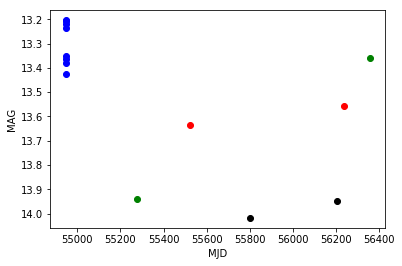

(292.2352304264401, 43.0936891516194, 'kplr2009115080620_ffi-cal.fits[46]')


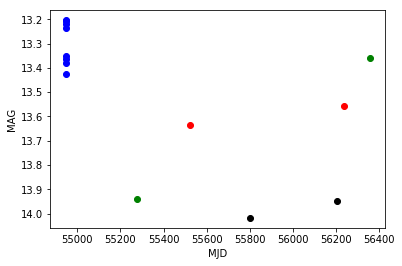

(292.23523049244886, 43.0936897017523, 'kplr2009115131122_ffi-cal.fits[46]')


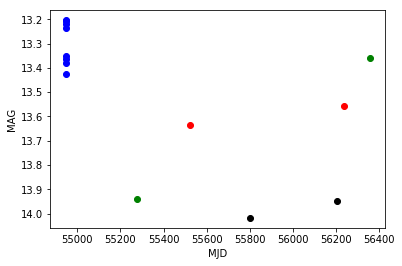

(292.2352301034367, 43.09368848492147, 'kplr2009115173611_ffi-cal.fits[46]')


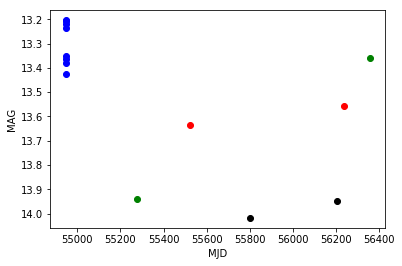

(292.23522908953754, 43.09369218659433, 'kplr2009116035924_ffi-cal.fits[46]')


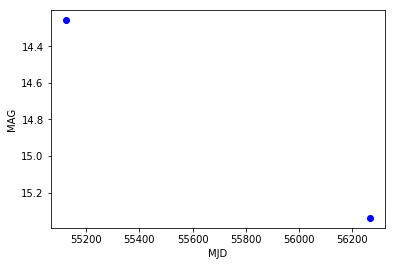

(288.1480409780076, 50.575179784264684, 'kplr2009292020429_ffi-cal.fits[31]')


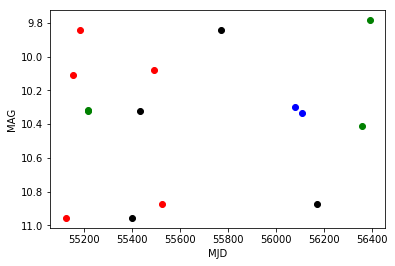

(296.1196248922269, 39.05817894056097, 'kplr2009322233047_ffi-cal.fits[35]')


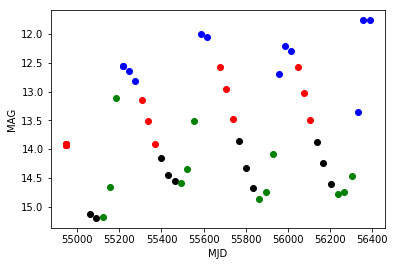

(284.20487551844514, 47.95321832161631, 'kplr2009351005245_ffi-cal.fits[69]')


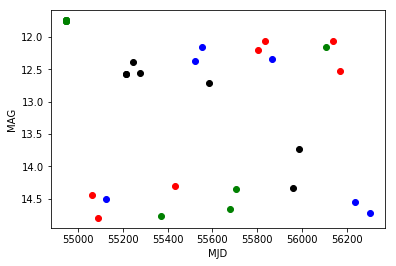

(299.2340422587743, 44.59021506079287, 'kplr2010019225502_ffi-cal.fits[53]')


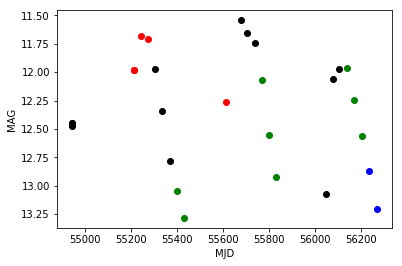

(296.0669514407137, 43.822180542826814, 'kplr2010019225502_ffi-cal.fits[59]')


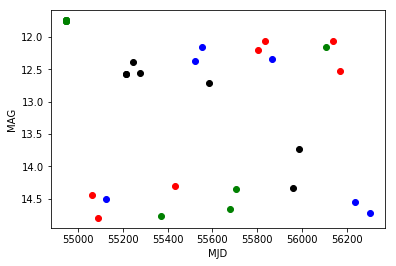

(299.2340415331356, 44.59021713810452, 'kplr2010020005046_ffi-cal.fits[53]')


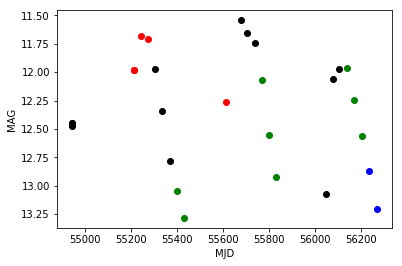

(296.0669555020045, 43.822174442187595, 'kplr2010020005046_ffi-cal.fits[59]')


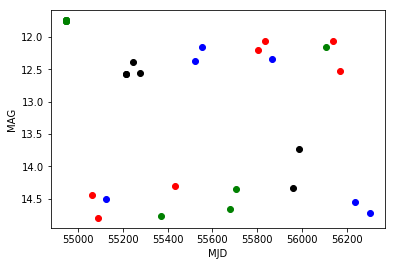

(299.2340716856979, 44.59023069611054, 'kplr2010049182302_ffi-cal.fits[53]')


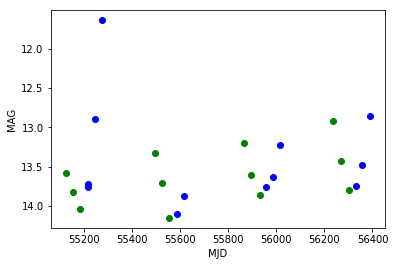

(295.6387386642805, 41.9375178849593, 'kplr2010049182302_ffi-cal.fits[57]')


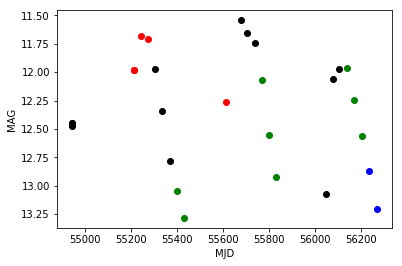

(296.0668281512721, 43.82213876299375, 'kplr2010049182302_ffi-cal.fits[59]')


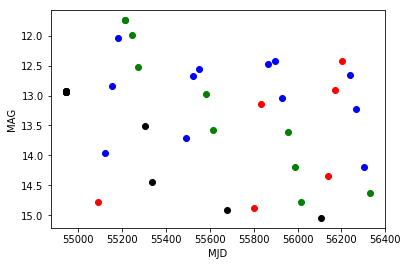

(292.3816285441276, 37.71147038839865, 'kplr2010049182302_ffi-cal.fits[83]')


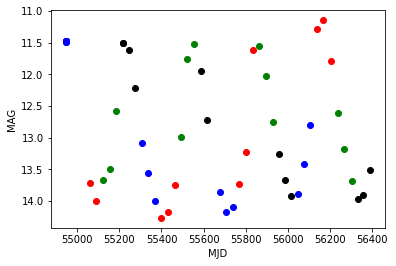

(299.04541570617823, 45.34972617784877, 'kplr2010078174524_ffi-cal.fits[54]')


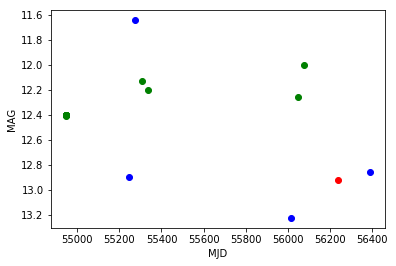

(295.63911447709575, 41.93785221877319, 'kplr2010078174524_ffi-cal.fits[57]')


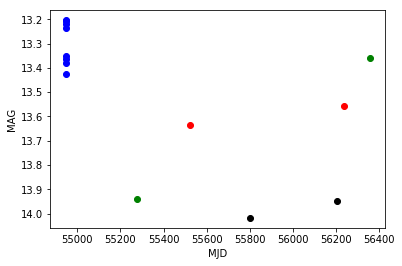

(292.23520576067165, 43.0937589591203, 'kplr2010078174524_ffi-cal.fits[62]')


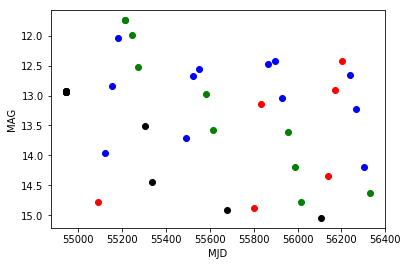

(292.3813388406311, 37.7115454245771, 'kplr2010078174524_ffi-cal.fits[83]')


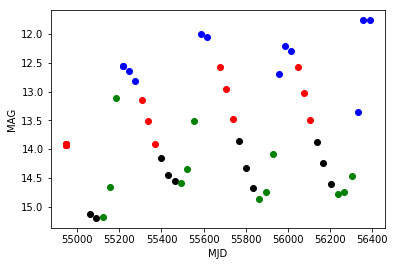

(284.20499639527685, 47.953124471972615, 'kplr2010111125026_ffi-cal.fits[13]')


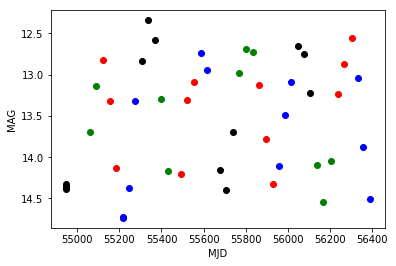

(291.4359254705428, 51.15885929182814, 'kplr2010111125026_ffi-cal.fits[53]')


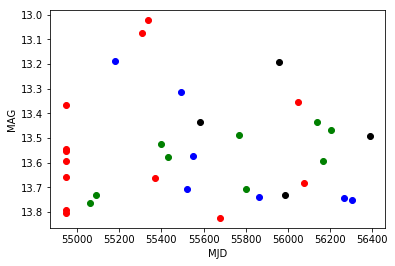

(283.3580550669622, 43.15458456551977, 'kplr2010140101631_ffi-cal.fits[2]')


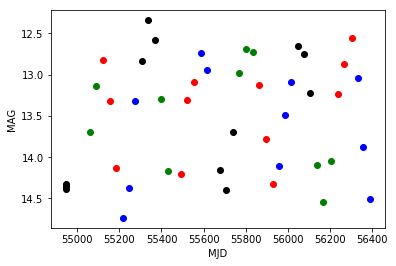

(291.43593325935973, 51.1588728232676, 'kplr2010140101631_ffi-cal.fits[53]')


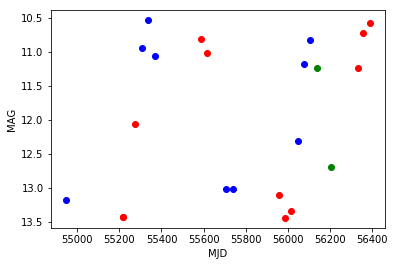

(292.9800401529574, 48.458518786548545, 'kplr2010140101631_ffi-cal.fits[57]')


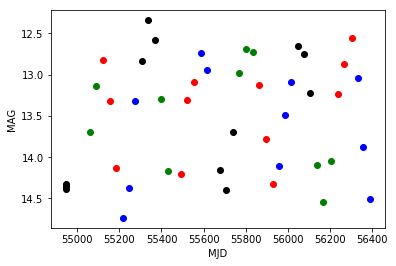

(291.43594106211066, 51.158905434676505, 'kplr2010174164113_ffi-cal.fits[53]')


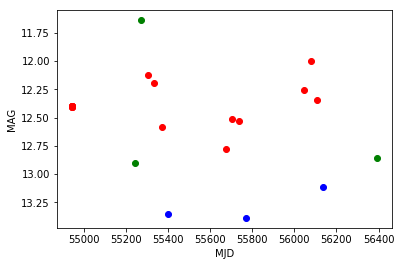

(295.6384237999255, 41.93811582933832, 'kplr2010203012215_ffi-cal.fits[25]')


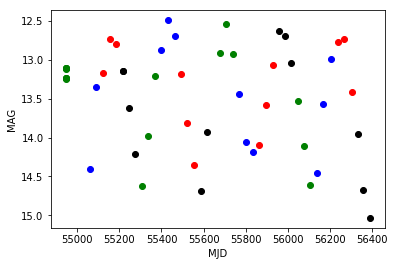

(297.00183318676926, 41.877386230219, 'kplr2010234192745_ffi-cal.fits[9]')


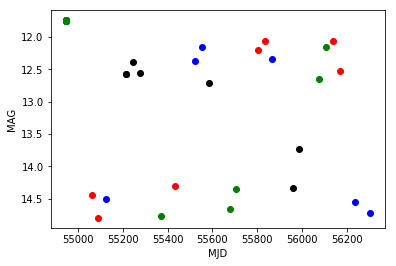

(299.2338589423969, 44.59035624286557, 'kplr2010326181728_ffi-cal.fits[1]')


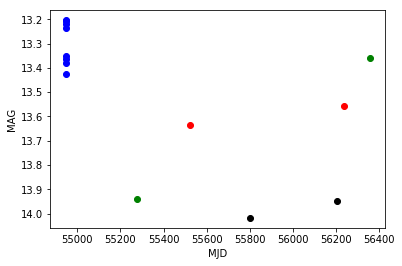

(292.23525590715076, 43.09376975642477, 'kplr2010326181728_ffi-cal.fits[38]')


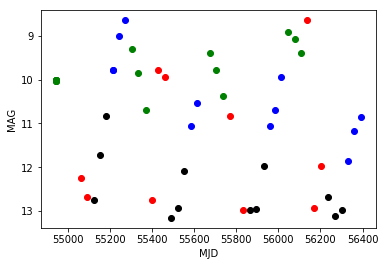

(296.0400777771668, 39.79020165751434, 'kplr2010356020128_ffi-cal.fits[35]')


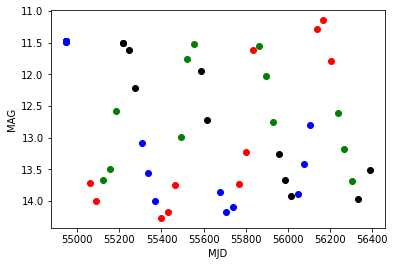

(299.04567324186604, 45.34963618296612, 'kplr2011024134926_ffi-cal.fits[54]')


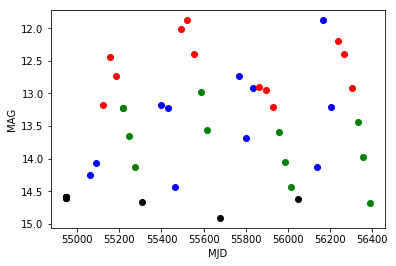

(294.61956267512113, 39.2306132589892, 'kplr2011024134926_ffi-cal.fits[80]')


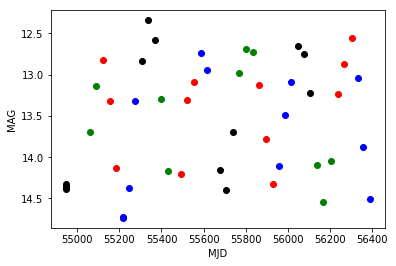

(291.43591269187334, 51.15895224727466, 'kplr2011053174401_ffi-cal.fits[1]')


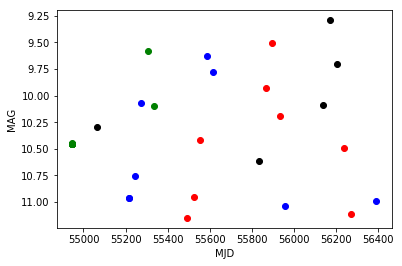

(291.6400224338254, 42.54421642107619, 'kplr2011053174401_ffi-cal.fits[61]')


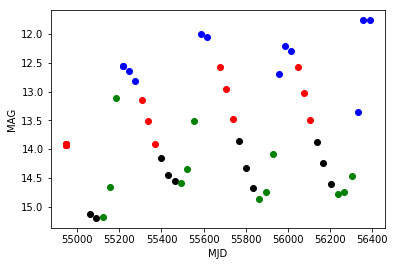

(284.20476783329747, 47.95311257750168, 'kplr2011116104002_ffi-cal.fits[13]')


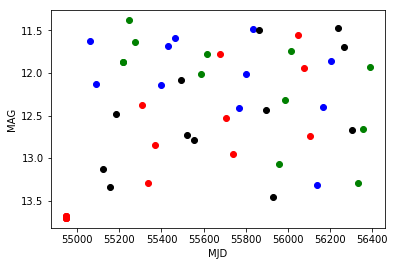

(289.7372561482753, 44.95703173189467, 'kplr2011116104002_ffi-cal.fits[43]')


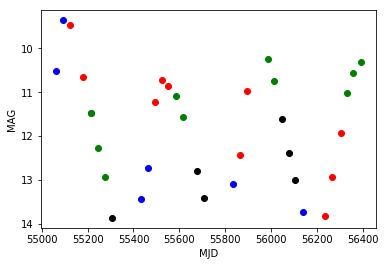

(298.33375917137886, 40.97142800044138, 'kplr2011116104002_ffi-cal.fits[71]')


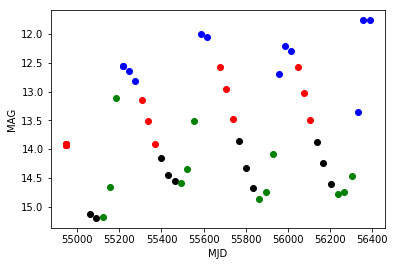

(284.2050026543789, 47.9531380184333, 'kplr2011145152723_ffi-cal.fits[13]')


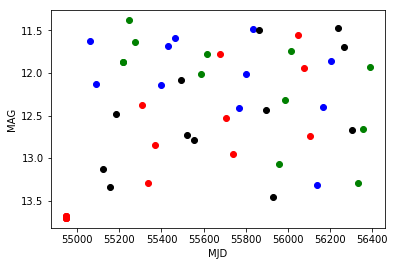

(289.73718894762254, 44.95668477448248, 'kplr2011145152723_ffi-cal.fits[43]')


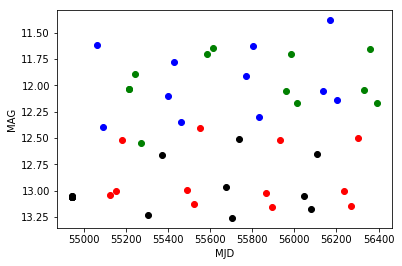

(292.93130944859956, 41.42710725210375, 'kplr2011177110110_ffi-cal.fits[48]')


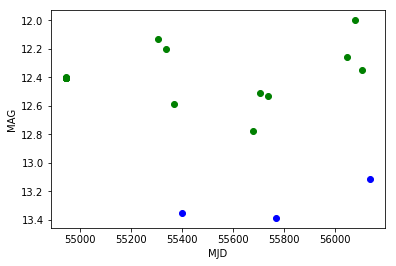

(295.6383417874262, 41.93817556982969, 'kplr2011208112727_ffi-cal.fits[25]')


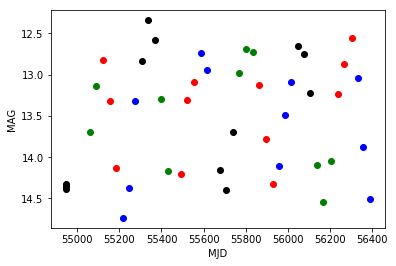

(291.4359286002956, 51.15877342735308, 'kplr2011240181752_ffi-cal.fits[81]')


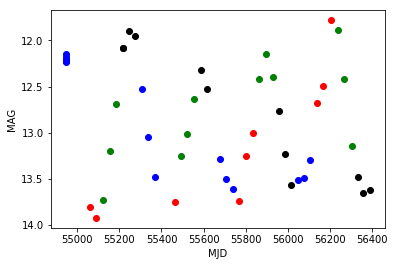

(298.47325250016206, 45.76887155390294, 'kplr2011271191331_ffi-cal.fits[30]')


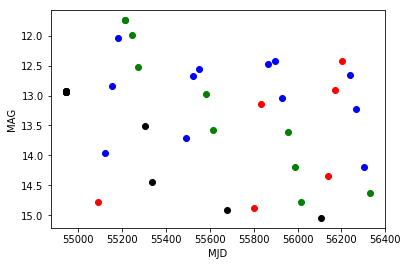

(292.3813052478641, 37.71123531004457, 'kplr2011271191331_ffi-cal.fits[3]')


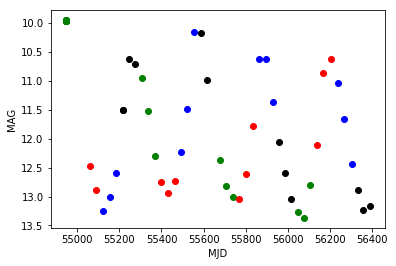

(289.97194631130805, 43.76206607368388, 'kplr2011271191331_ffi-cal.fits[43]')


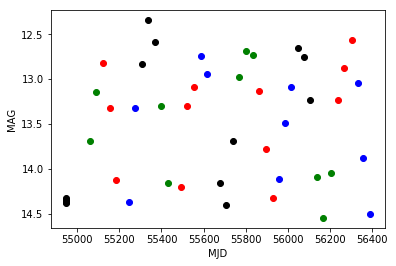

(291.4360281946108, 51.15886664533195, 'kplr2011271191331_ffi-cal.fits[81]')


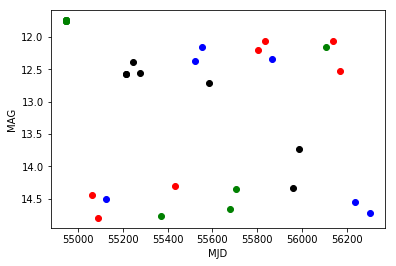

(299.23401498853497, 44.59019071296847, 'kplr2011303191211_ffi-cal.fits[1]')


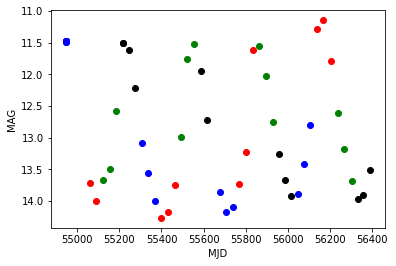

(299.0452838500246, 45.34951549523086, 'kplr2011303191211_ffi-cal.fits[2]')


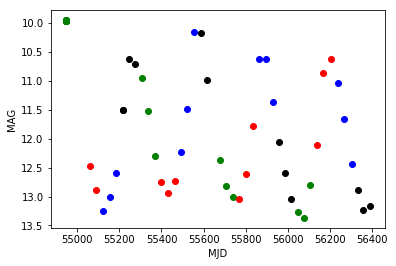

(289.9726693084478, 43.76177186903788, 'kplr2011334181008_ffi-cal.fits[44]')


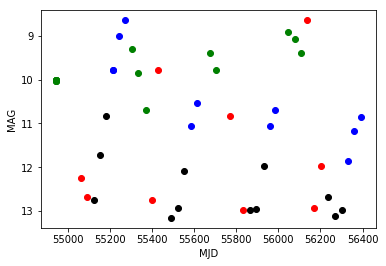

(296.0402198571459, 39.78985900570338, 'kplr2012004204112_ffi-cal.fits[35]')


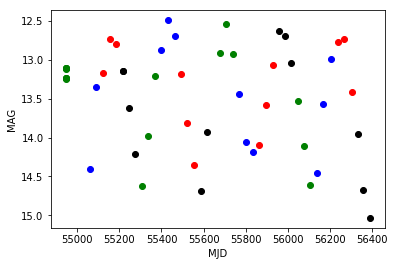

(297.00216886176247, 41.87767262847166, 'kplr2012032101442_ffi-cal.fits[73]')


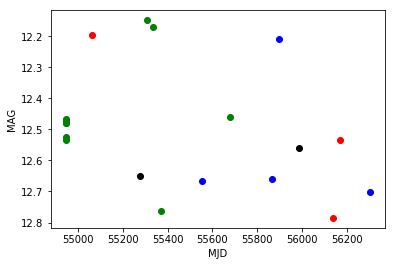

(299.1365897925477, 43.627482113163545, 'kplr2012060123308_ffi-cal.fits[53]')


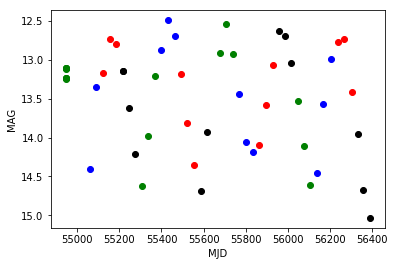

(297.00209870714417, 41.87770281675561, 'kplr2012060123308_ffi-cal.fits[73]')


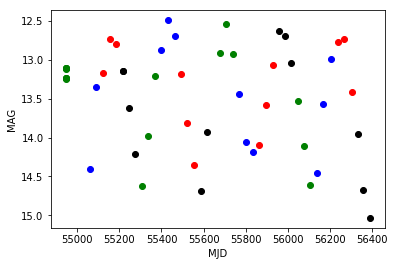

(297.00197502764473, 41.87749419803092, 'kplr2012088132324_ffi-cal.fits[73]')


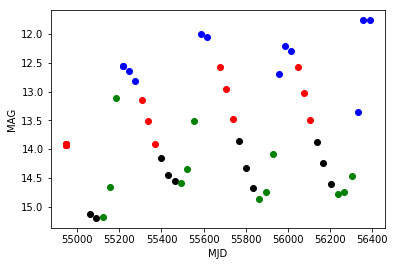

(284.20480150128714, 47.95312573206647, 'kplr2012121122500_ffi-cal.fits[13]')


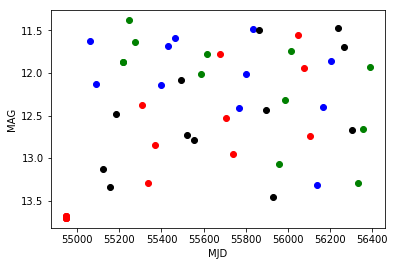

(289.73726353031634, 44.95702723302261, 'kplr2012121122500_ffi-cal.fits[43]')


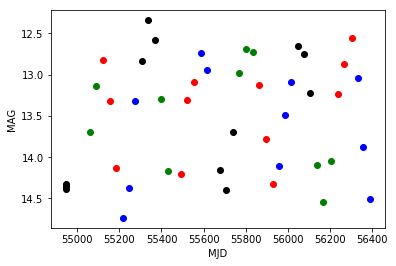

(291.43593232666944, 51.15887740349186, 'kplr2012121122500_ffi-cal.fits[53]')


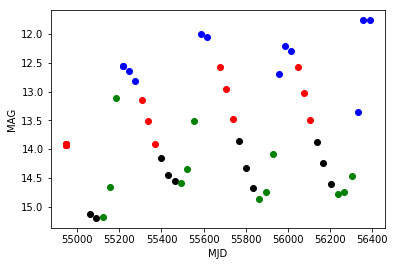

(284.204973145675, 47.95314797561404, 'kplr2012151105138_ffi-cal.fits[13]')


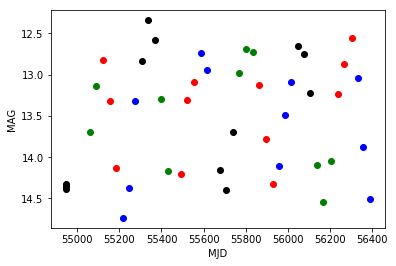

(291.4359309585661, 51.158901149659066, 'kplr2012151105138_ffi-cal.fits[53]')


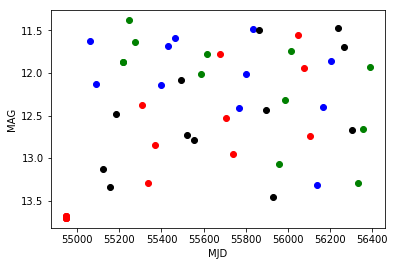

(289.73748548067465, 44.95660380504966, 'kplr2012179140901_ffi-cal.fits[43]')


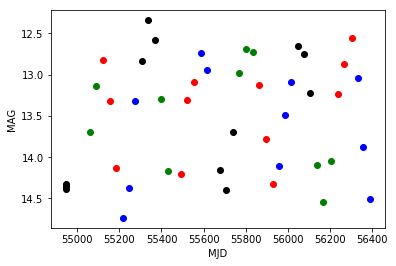

(291.43593409943276, 51.15892321087754, 'kplr2012179140901_ffi-cal.fits[53]')


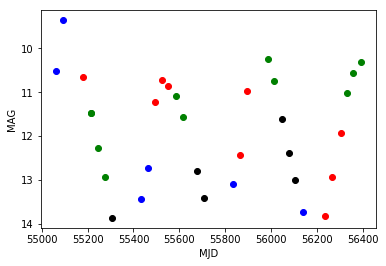

(298.33352975075655, 40.97138596063402, 'kplr2012179140901_ffi-cal.fits[71]')


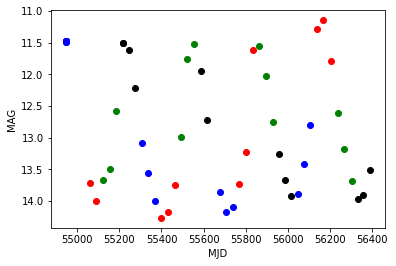

(299.0445753599226, 45.349499039592885, 'kplr2012211123923_ffi-cal.fits[30]')


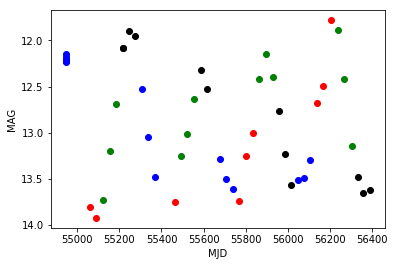

(298.47339298249125, 45.768917203710934, 'kplr2012211123923_ffi-cal.fits[30]')


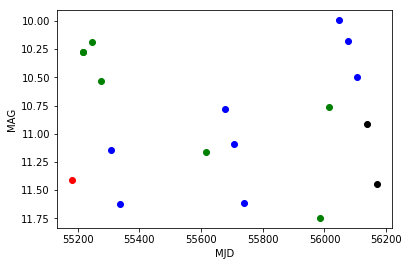

(297.10947695797336, 42.55765134284125, 'kplr2012242195726_ffi-cal.fits[28]')


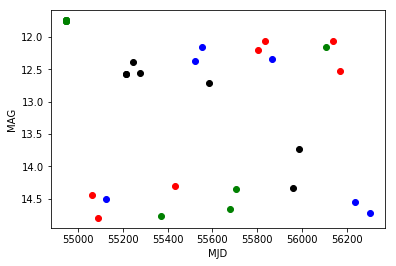

(299.2338417230717, 44.5902121555041, 'kplr2012242195726_ffi-cal.fits[29]')


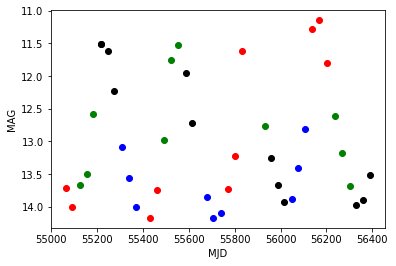

(299.04421736545754, 45.349610428925665, 'kplr2012242195726_ffi-cal.fits[30]')


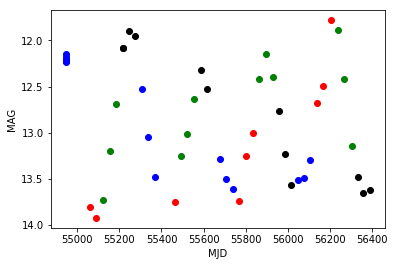

(298.47291784467933, 45.76871139505617, 'kplr2012242195726_ffi-cal.fits[30]')


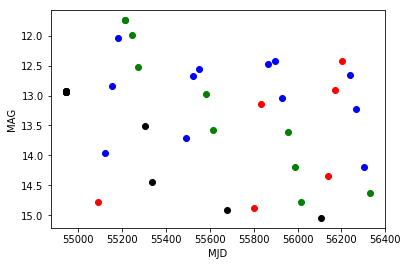

(292.3812911872557, 37.7111963697075, 'kplr2012242195726_ffi-cal.fits[3]')


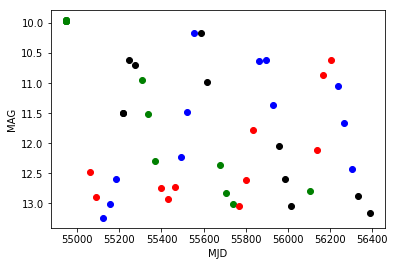

(289.97226183795823, 43.76226954544023, 'kplr2012242195726_ffi-cal.fits[43]')


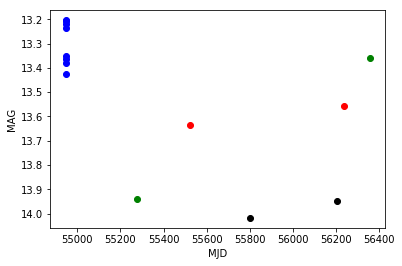

(292.23523419475157, 43.09379951828043, 'kplr2012277203051_ffi-cal.fits[22]')


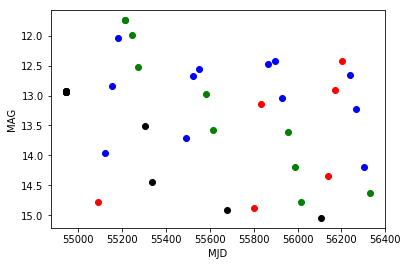

(292.38128035854936, 37.71125550421679, 'kplr2012277203051_ffi-cal.fits[3]')


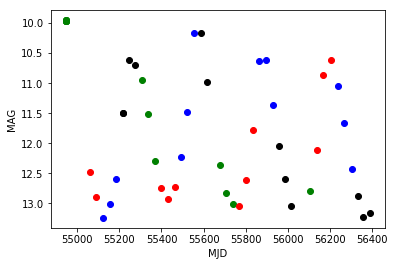

(289.9718739605204, 43.76224197948193, 'kplr2012277203051_ffi-cal.fits[43]')


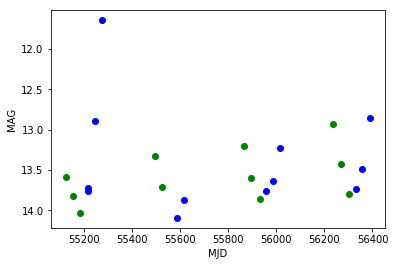

(295.6387687430109, 41.93750750040188, 'kplr2012310200152_ffi-cal.fits[17]')


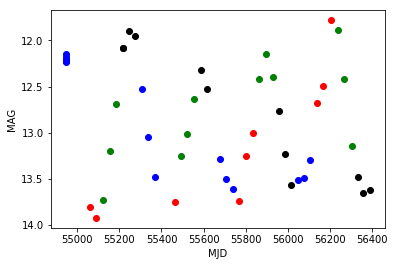

(298.47354008954403, 45.76915347944928, 'kplr2012310200152_ffi-cal.fits[2]')


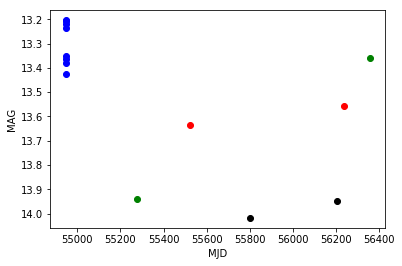

(292.23521430015495, 43.09380968431812, 'kplr2012310200152_ffi-cal.fits[38]')


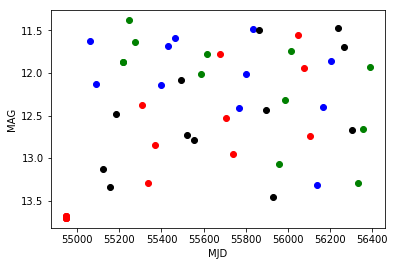

(289.73780053197385, 44.95651387441097, 'kplr2012341215621_ffi-cal.fits[41]')


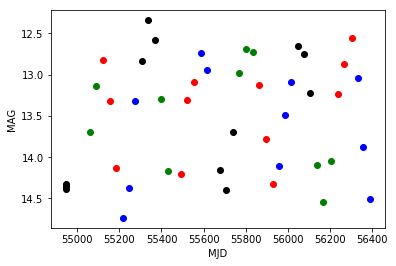

(291.43593790407425, 51.15891516093286, 'kplr2013011160902_ffi-cal.fits[29]')


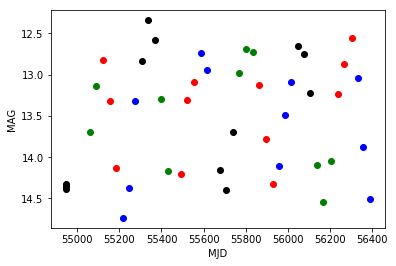

(291.43593661740476, 51.15892606573845, 'kplr2013038133130_ffi-cal.fits[1]')


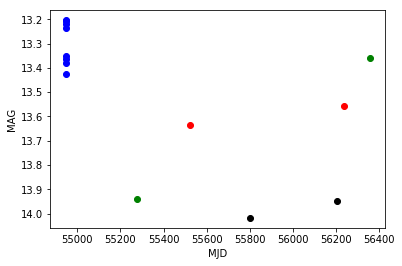

(292.2352209010263, 43.09376755458721, 'kplr2013065115251_ffi-cal.fits[62]')


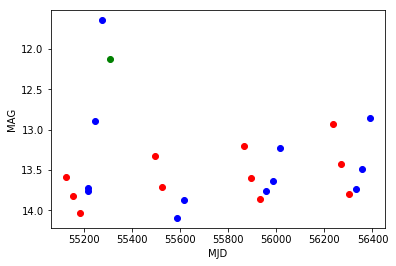

(295.63874497345654, 41.93756056694521, 'kplr2013098115308_ffi-cal.fits[57]')


[[[54945.72162632],
  [55801.74198404,
   54945.72162632,
   54945.84664962,
   54946.31730352,
   56236.81420744,
   55274.71942834,
   54945.99778262,
   54947.14581722,
   56203.83432484,
   54946.71303422,
   55522.74170174,
   56357.47460744,
   54946.21309222,
   54946.52913182],
  [55801.74198404,
   54945.72162632,
   54945.84664962,
   54946.31730352,
   56236.81420744,
   55274.71942834,
   54945.99778262,
   54947.14581722,
   56203.83432484,
   54946.71303422,
   55522.74170174,
   56357.47460744,
   54946.21309222,
   54946.52913182],
  [55801.74198404,
   54945.72162632,
   54945.84664962,
   54946.31730352,
   56236.81420744,
   55274.71942834,
   54945.99778262,
   54947.14581722,
   56203.83432484,
   54946.71303422,
   55522.74170174,
   56357.47460744,
   54946.21309222,
   54946.52913182],
  [55801.74198404,
   54945.72162632,
   54945.84664962,
   54946.31730352,
   56236.81420744,
   55274.71942834,
   54945.99778262,
   54947.14581722,
   56203.83432484,
   54946

In [41]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/matchSNabove10.csv')
makeLightCurves(origTab)

In [ ]:
print(a)

('kplr2009114174833_ffi-cal.fits[12]', '12')
('index 0', 1)
('kplr2009114174833_ffi-cal.fits[13]', '13')
('index 1', 1)
('kplr2009114174833_ffi-cal.fits[15]', '15')
('index 2', 1)
('kplr2009114174833_ffi-cal.fits[16]', '16')
('index 3', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 4', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 5', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 6', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 7', 1)
('kplr2009114174833_ffi-cal.fits[24]', '24')
('index 8', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
('kplr2009114174833_ffi-cal.fits[36]', '36')
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr20120

Redo file kplr2012341215621_ffi-cal.fits[6]
Redo file kplr2010296192119_ffi-cal.fits[6]
Redo file kplr2012310200152_ffi-cal.fits[6]
('kplr2009115002613_ffi-cal.fits[78]', '78')
Redo file kplr2012004204112_ffi-cal.fits[6]
Redo file kplr2010356020128_ffi-cal.fits[6]
Redo file kplr2010326181728_ffi-cal.fits[6]
('index 62', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2009115002613_ffi-cal.fits[7]', '7')
('index 63', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 64', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 65', 1)
('kplr2009115053616_ffi-cal.fits[15]', '15')
('index 66', 1)
('kplr2009115053616_ffi-cal.fits[15]'

Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 112', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 113', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits

kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 156', 14)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 157', 1)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 158', 1)
('kplr2009116035924_ffi-cal.fits[60]', '60')
('index 159', 1)
Redo file kplr2012121122500_ffi-cal.fits[6]
Redo file kplr2010111125026_ffi-cal.fits[6]
Redo file kplr2011177110110_ffi-cal.fits[6]
Redo file kplr2010174164113_ffi-cal.fits[6]
Redo file kplr2011116104002_ffi-cal.fits[6]
Redo file kplr2010140101631_ffi-cal.fits[6]
Redo file kplr2012179140901_ffi-cal.fits[6]
Redo file kplr2011145152723_ffi-cal.fits[6]
Redo file kplr2012151105138_ffi-cal.fits[6]
('kplr2009116035924_ffi-cal.fits[6]', '6')
('index 160', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo f

Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 195', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
('kplr2009260000800_ffi-cal.fits[79]', '79')
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 196', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
('kplr2009260000800_ffi-cal.fits[79]', '7

kplr2011240181752_ffi-cal.fits[73]
kplr2009322233047_ffi-cal.fits[69]
kplr2010111125026_ffi-cal.fits[13]
kplr2011177110110_ffi-cal.fits[13]
kplr2013011160902_ffi-cal.fits[69]
kplr2011271191331_ffi-cal.fits[73]
kplr2010174164113_ffi-cal.fits[13]
kplr2012088132324_ffi-cal.fits[9]
kplr2010265195356_ffi-cal.fits[73]
kplr2009114174833_ffi-cal.fits[13]
kplr2011303191211_ffi-cal.fits[69]
kplr2011334181008_ffi-cal.fits[69]
kplr2009260000800_ffi-cal.fits[73]
kplr2009114204835_ffi-cal.fits[13]
kplr2012341215621_ffi-cal.fits[69]
kplr2009115080620_ffi-cal.fits[13]
kplr2010296192119_ffi-cal.fits[69]
kplr2013038133130_ffi-cal.fits[9]
kplr2011116104002_ffi-cal.fits[13]
kplr2010140101631_ffi-cal.fits[13]
kplr2010019225502_ffi-cal.fits[9]
kplr2012310200152_ffi-cal.fits[69]
kplr2013098115308_ffi-cal.fits[9]
kplr2010020005046_ffi-cal.fits[9]
kplr2010234192745_ffi-cal.fits[73]
kplr2012179140901_ffi-cal.fits[13]
kplr2009351005245_ffi-cal.fits[69]
kplr2011208112727_ffi-cal.fits[73]
kplr2009231194831_ffi-cal

Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2010049182302_ffi-cal.fits[51]', '51')
('index 304', 1)
('kplr2010049182302_ffi-cal.fits[9]', '9')
('index 305', 1)
('kplr2010078174524_ffi-cal.fits[12]', '12')
('index 306', 1)
('kplr2010078174524_ffi-cal.fits[13]', '13')
('index 307', 1)
('kplr2010078174524_ffi-cal.fits[17]', '17')
('index 308', 1)
('kplr2010078174524_ffi-cal.fits[21]', '21')
('index 309', 1)
('kplr2010078174524_ffi-cal.fits[22]', '22')
('index 310', 1)
('kplr2010078174524_ffi-cal.fits[29]', '29')
('index 311', 1)
('kplr2010078174524_ffi-cal.fits[29]', '29')
('index 312', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
('kp

kplr2009351005245_ffi-cal.fits[29]
kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.fits[1]
kplr2012151105138_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.fits[29]
kplr2010326181728_ffi-cal.fits[29]
kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.fits[1]
kplr2012060123308_ffi-cal.fits[1]
('index 353', 50)
('kplr2010140101631_ffi-cal.fits[54]', '54')
('index 354', 1)
('kplr2010140101631_ffi-cal.fits[58]', '58')
('index

Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 394', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
('kplr2010203012215_ffi-cal.fits[80]', '80')
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 395', 1)
('kplr2010203012215_ffi-cal.fits[83]', '83')
('index 396', 1)
('kplr2010203012215_ffi-cal.fits[83]', '83')
('index 397', 1)
('kplr2010203012215_ffi-cal.fits[83]', '83')
('index 398', 1)
('kplr2010203012215_ffi-cal.fit

Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 438', 1)
('kplr2010265195356_ffi-cal.fits[83]', '83')
('index 439', 1)
('kplr2010265195356_ffi-cal.fits[83]', '83')
('index 440', 1)
('kplr2010296192119_ffi-cal.fits[23]', '23')
('index 441', 1)
('kplr2010296192119_ffi-cal.fits[30]', '30')
('index 442', 1)
Redo file kplr2012088132324_ffi-cal.fits[5]
('kplr2010296192119_ffi-cal.fits[49]', '49')
Redo file kplr2013038133130_ffi-cal.fits[5]
Redo file kplr2010019225502_ffi-cal.fits[5]
Redo file kplr2013098115308_ffi-cal.fits[5]
Redo file kplr2010020005046_ff

('kplr2011024134926_ffi-cal.fits[50]', '50')
Redo file kplr2012151105138_ffi-cal.fits[6]
('index 495', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
('kplr2011024134926_ffi-cal.fits[52]', '52')
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 496', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
('kplr2011024134926_ffi-cal.fits[52]', '52')
Redo file kplr2012151105138_ffi-cal.fit

('kplr2011177110110_ffi-cal.fits[19]', '19')
('index 552', 1)
('kplr2011177110110_ffi-cal.fits[21]', '21')
('index 553', 1)
('kplr2011177110110_ffi-cal.fits[2]', '2')
('index 554', 1)
('kplr2011177110110_ffi-cal.fits[36]', '36')
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 555', 1)
('kplr2011177110110_ffi-cal.fits[4]', '4')
('index 556', 1)
('kplr2011177110110_ffi-cal.fits[4]', '4')
('index 557', 1)
('kplr2011177110110_ffi-cal.fits[56]', '56')
('index 558', 1)
('kplr2011177110110_ffi-cal.fits[56]', '56')

('kplr2011240181752_ffi-cal.fits[84]', '84')
('index 597', 1)
('kplr2011271191331_ffi-cal.fits[16]', '16')
('index 598', 1)
('kplr2011271191331_ffi-cal.fits[16]', '16')
('index 599', 1)
('kplr2011271191331_ffi-cal.fits[16]', '16')
('index 600', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
('kplr2011271191331_ffi-cal.fits[35]', '35')
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('index 601', 1)
('kplr2011240181752_ffi-cal.fits[3]', '3')
kplr2009322233047_ffi-cal.fits[55]
kplr2010111125026_ffi-cal.fits[31]
kplr2013011160902_ffi-cal.fits[55]
kplr2011271191331_ffi-cal.fits[3]
kplr2012088132324_ffi-cal.fits[83]
kplr2009114174833_ffi-cal.fits[31]
kplr2011303191211_ffi-cal.fits[55]
kplr201

Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
('kplr2011334181008_ffi-cal.fits[79]', '79')
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('index 642', 1)
('kplr2011334181008_ffi-cal.fits[82]', '82')
('index 643', 1)
('kplr2011334181008_ffi-cal.fits[83]', '83')
('index 644', 1)
('kplr2011334181008_ffi-cal.fits[83]', '83')
('index 645', 1)
('kplr2012004204112_ffi-cal.fits[29]', '29')
('index 646', 1)
('kplr2012004204112_ffi-cal.fits[29]', '29')
('index 647', 1)
('kplr2012004204112_ffi-cal.fits[31]', '31')
('index 648', 1)
('kplr2012004204112_ffi-cal.fits[41]', '41')
('index 649', 1)
('kplr2012004204112_ffi-cal.fits[46]', '46')
('index 650', 1)
('kplr2012004204112_ffi-cal.fits[47]', '47')
('index 651', 1)
Redo file kplr2012088132324_

kplr2010019225502_ffi-cal.fits[1]
kplr2012310200152_ffi-cal.fits[29]
kplr2013098115308_ffi-cal.fits[1]
kplr2010234192745_ffi-cal.fits[81]
kplr2012179140901_ffi-cal.fits[53]
kplr2009351005245_ffi-cal.fits[29]
kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.fits[1]
kplr2012151105138_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.fits[29]
kplr2010326181728_ffi-cal.fits[29]
kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.f

kplr2009114204835_ffi-cal.fits[53]
kplr2012341215621_ffi-cal.fits[29]
kplr2009115080620_ffi-cal.fits[53]
kplr2010296192119_ffi-cal.fits[29]
kplr2013038133130_ffi-cal.fits[1]
kplr2011116104002_ffi-cal.fits[53]
kplr2010140101631_ffi-cal.fits[53]
kplr2010019225502_ffi-cal.fits[1]
kplr2012310200152_ffi-cal.fits[29]
kplr2013098115308_ffi-cal.fits[1]
kplr2010234192745_ffi-cal.fits[81]
kplr2012179140901_ffi-cal.fits[53]
kplr2009351005245_ffi-cal.fits[29]
kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.fits[1]
kplr2012151105138_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.

kplr2013011160902_ffi-cal.fits[55]
kplr2011271191331_ffi-cal.fits[3]
kplr2012088132324_ffi-cal.fits[83]
kplr2009114174833_ffi-cal.fits[31]
kplr2011303191211_ffi-cal.fits[55]
kplr2011334181008_ffi-cal.fits[55]
kplr2009260000800_ffi-cal.fits[3]
kplr2009114204835_ffi-cal.fits[31]
kplr2012341215621_ffi-cal.fits[55]
kplr2009115080620_ffi-cal.fits[31]
kplr2010296192119_ffi-cal.fits[55]
kplr2013038133130_ffi-cal.fits[83]
kplr2011116104002_ffi-cal.fits[31]
kplr2010140101631_ffi-cal.fits[31]
kplr2010019225502_ffi-cal.fits[83]
kplr2012310200152_ffi-cal.fits[55]
kplr2010020005046_ffi-cal.fits[83]
kplr2012179140901_ffi-cal.fits[31]
kplr2009351005245_ffi-cal.fits[55]
kplr2010078174524_ffi-cal.fits[83]
kplr2012211123923_ffi-cal.fits[3]
kplr2011053174401_ffi-cal.fits[83]
kplr2011024134926_ffi-cal.fits[83]
kplr2009115002613_ffi-cal.fits[31]
kplr2009116035924_ffi-cal.fits[31]
kplr2009292020429_ffi-cal.fits[55]
kplr2012004204112_ffi-cal.fits[55]
kplr2012277203051_ffi-cal.fits[3]
kplr2009115173611_ffi-ca

Redo file kplr2012088132324_ffi-cal.fits[5]
Redo file kplr2013038133130_ffi-cal.fits[5]
Redo file kplr2010019225502_ffi-cal.fits[5]
Redo file kplr2013098115308_ffi-cal.fits[5]
Redo file kplr2010020005046_ffi-cal.fits[5]
Redo file kplr2010078174524_ffi-cal.fits[5]
Redo file kplr2011053174401_ffi-cal.fits[5]
Redo file kplr2011024134926_ffi-cal.fits[5]
Redo file kplr2013065115251_ffi-cal.fits[5]
Redo file kplr2012032101442_ffi-cal.fits[5]
Redo file kplr2010049182302_ffi-cal.fits[5]
Redo file kplr2012060123308_ffi-cal.fits[5]
('index 815', 1)
('kplr2013011160902_ffi-cal.fits[51]', '51')
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr

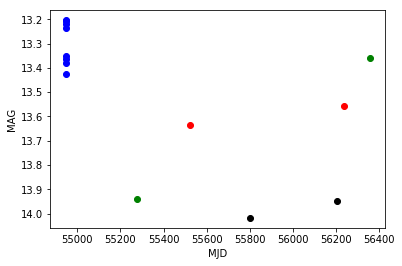

(292.2352304264401, 43.0936891516194, 'kplr2009115080620_ffi-cal.fits[46]')


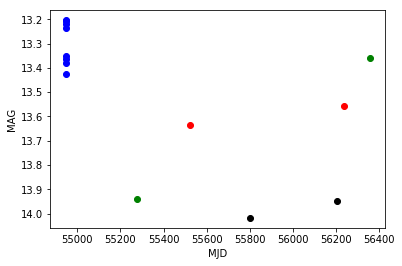

(292.23523049244886, 43.0936897017523, 'kplr2009115131122_ffi-cal.fits[46]')


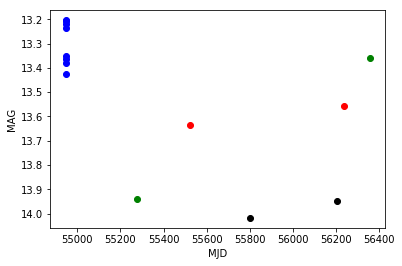

(292.2352301034367, 43.09368848492147, 'kplr2009115173611_ffi-cal.fits[46]')


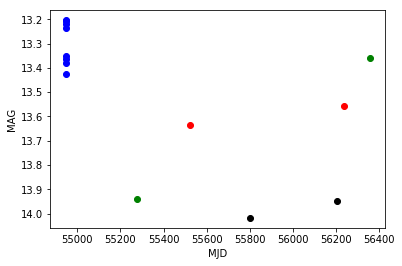

(292.23522908953754, 43.09369218659433, 'kplr2009116035924_ffi-cal.fits[46]')


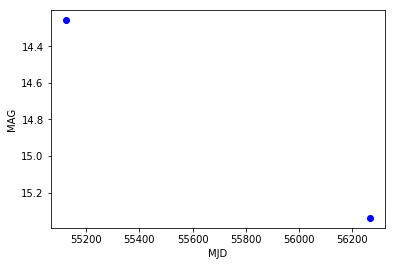

(288.1480409780076, 50.575179784264684, 'kplr2009292020429_ffi-cal.fits[31]')


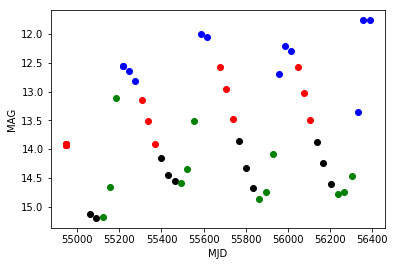

(284.20487551844514, 47.95321832161631, 'kplr2009351005245_ffi-cal.fits[69]')


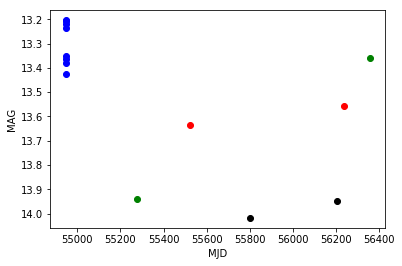

(292.23520576067165, 43.0937589591203, 'kplr2010078174524_ffi-cal.fits[62]')


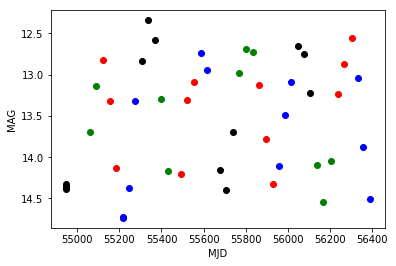

(291.4359254705428, 51.15885929182814, 'kplr2010111125026_ffi-cal.fits[53]')


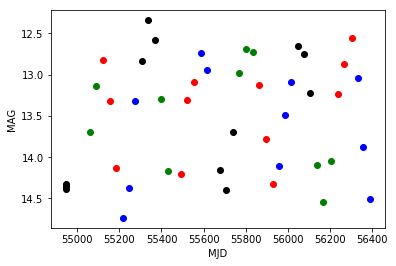

(291.43593325935973, 51.1588728232676, 'kplr2010140101631_ffi-cal.fits[53]')


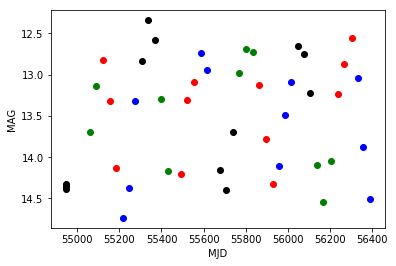

(291.43594106211066, 51.158905434676505, 'kplr2010174164113_ffi-cal.fits[53]')


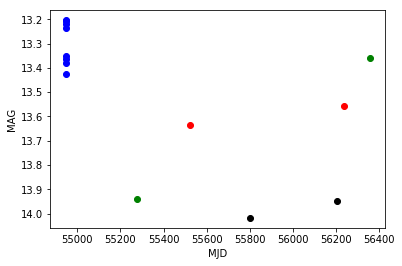

(292.23525590715076, 43.09376975642477, 'kplr2010326181728_ffi-cal.fits[38]')


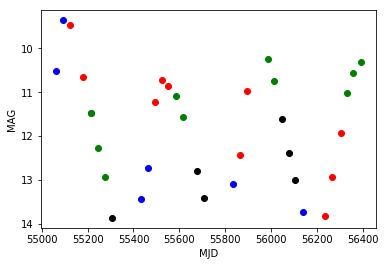

(298.33375917137886, 40.97142800044138, 'kplr2011116104002_ffi-cal.fits[71]')


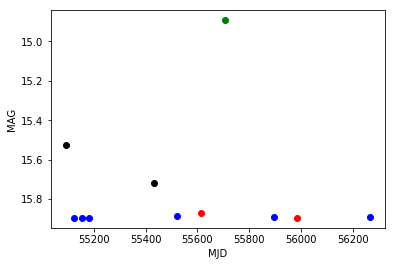

(294.6668925303648, 50.45855027469197, 'kplr2011145152723_ffi-cal.fits[74]')


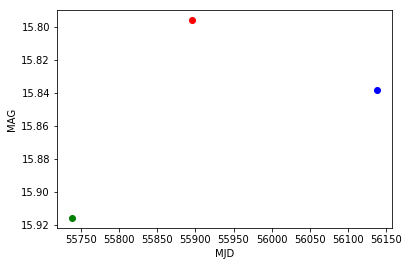

(292.20832134632974, 46.464068835819646, 'kplr2011177110110_ffi-cal.fits[62]')


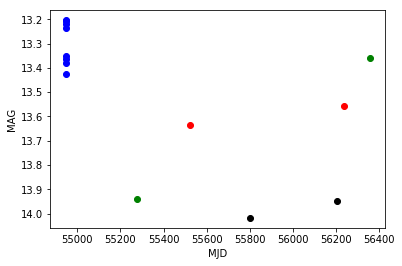

(292.23525867991003, 43.09377632603181, 'kplr2011240181752_ffi-cal.fits[22]')


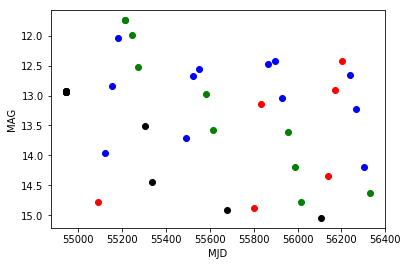

(292.3813052478641, 37.71123531004457, 'kplr2011271191331_ffi-cal.fits[3]')


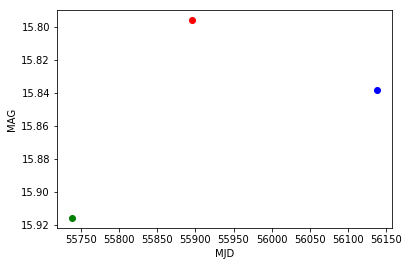

(292.20836218926235, 46.46419760319968, 'kplr2011334181008_ffi-cal.fits[22]')


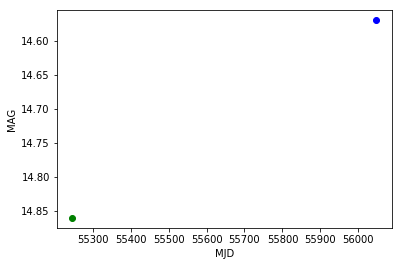

(288.4934079182069, 40.73577466652988, 'kplr2012121122500_ffi-cal.fits[25]')


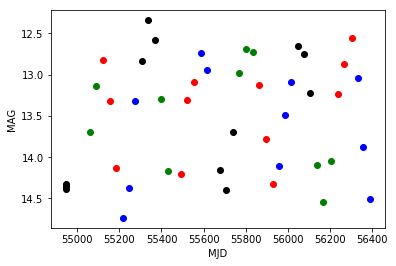

(291.43593232666944, 51.15887740349186, 'kplr2012121122500_ffi-cal.fits[53]')


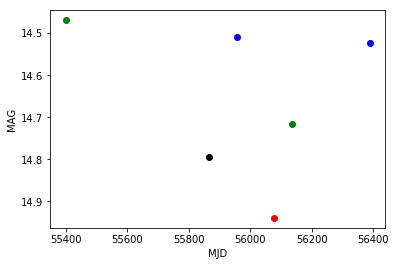

(281.16305305702406, 43.37459426241148, 'kplr2012151105138_ffi-cal.fits[4]')


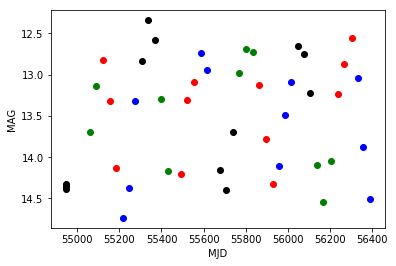

(291.4359309585661, 51.158901149659066, 'kplr2012151105138_ffi-cal.fits[53]')


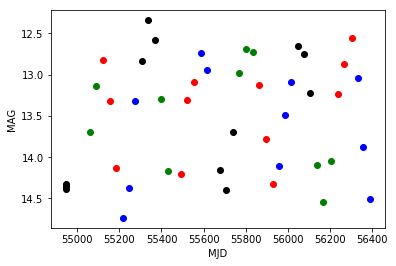

(291.43593409943276, 51.15892321087754, 'kplr2012179140901_ffi-cal.fits[53]')


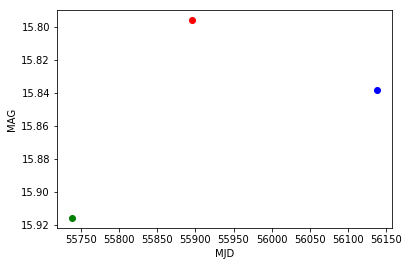

(292.2084021086923, 46.4642218707108, 'kplr2012211123923_ffi-cal.fits[46]')


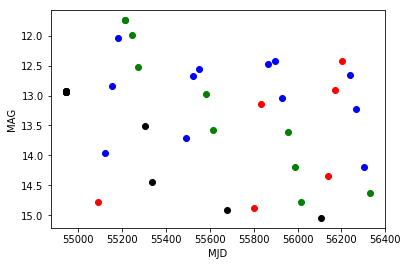

(292.3812911872557, 37.7111963697075, 'kplr2012242195726_ffi-cal.fits[3]')


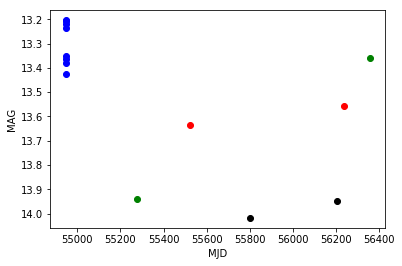

(292.23523419475157, 43.09379951828043, 'kplr2012277203051_ffi-cal.fits[22]')


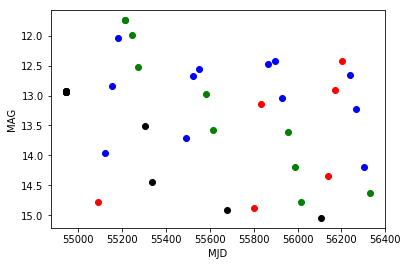

(292.38128035854936, 37.71125550421679, 'kplr2012277203051_ffi-cal.fits[3]')


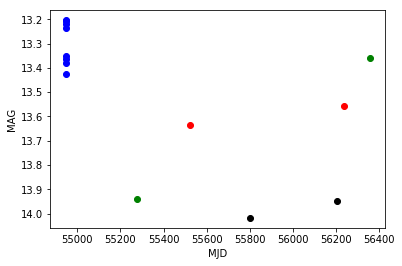

(292.23521430015495, 43.09380968431812, 'kplr2012310200152_ffi-cal.fits[38]')


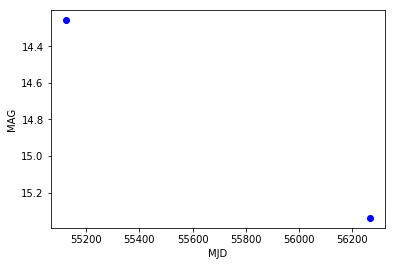

(288.14798518324847, 50.57520062753317, 'kplr2012341215621_ffi-cal.fits[31]')


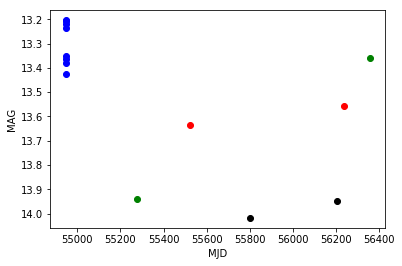

(292.2352209010263, 43.09376755458721, 'kplr2013065115251_ffi-cal.fits[62]')


In [35]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/magone.csv')
outputSmoll = makeLightCurves(origTab)

In [36]:
print(output[0])

[[54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99

In [37]:
print(output[1])

[[16.1003], [16.9888], [16.9315], [16.776], [16.2405], [16.1544], [14.4266], [14.8043], [16.7348], [16.5388], [16.3768], [15.5417], [15.3236], [16.3195], [15.6635], [15.0062], [16.4726], [15.7855], [16.484], [16.3442], [16.4713], [16.727], [16.1744], [15.4442], [16.1066], [16.1615], [16.3659], [16.1089], [16.7169], [16.8988], [16.8516], [16.0444], [16.5279], [16.8775], [16.0662], [15.5721], [16.206], [15.002], [16.3745], [16.1656], [16.7292], [15.3394], [16.6347], [15.851], [15.8506], [16.8753], [16.4037], [16.5439], [15.7462], [16.7723], [16.3143], [15.8123], [16.6514], [15.9275], [16.0119], [15.3219], [15.7012], [16.3662], [15.7668], [16.2449], [15.2556], [15.3419], [14.6697], [15.6641], [16.8199], [16.8899], [15.0204], [15.6184], [17.1596], [16.1568], [15.6479], [16.6355], [16.117], [15.9253], [16.2124], [16.5516], [16.2446], [15.6277], [15.5495], [16.004], [16.208], [16.0622], [15.498], [15.4826], [16.7398], [15.4922], [16.6922], [15.709], [16.5264], [16.651], [16.4931], [15.7938],

In [38]:
print(output[2])

['b*', 'g*', 'r*', 'k*']


('kplr2009114174833_ffi-cal.fits[12]', '12')
('index 0', 1)
('kplr2009114174833_ffi-cal.fits[13]', '13')
('index 1', 1)
('kplr2009114174833_ffi-cal.fits[15]', '15')
('index 2', 1)
('kplr2009114174833_ffi-cal.fits[16]', '16')
('index 3', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 4', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 5', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 6', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 7', 1)
('kplr2009114174833_ffi-cal.fits[24]', '24')
('index 8', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
('kplr2009114174833_ffi-cal.fits[36]', '36')
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr20120

Redo file kplr2012341215621_ffi-cal.fits[6]
Redo file kplr2010296192119_ffi-cal.fits[6]
Redo file kplr2012310200152_ffi-cal.fits[6]
('kplr2009115002613_ffi-cal.fits[78]', '78')
Redo file kplr2012004204112_ffi-cal.fits[6]
Redo file kplr2010356020128_ffi-cal.fits[6]
Redo file kplr2010326181728_ffi-cal.fits[6]
('index 62', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2009115002613_ffi-cal.fits[7]', '7')
('index 63', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 64', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 65', 1)
('kplr2009115053616_ffi-cal.fits[15]', '15')
('index 66', 1)
('kplr2009115053616_ffi-cal.fits[15]'

Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 112', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 113', 1)
Redo file kplr2012088132324_ffi-cal.fits

kplr2010174164113_ffi-cal.fits[46]
kplr2009114174833_ffi-cal.fits[46]
kplr2011334181008_ffi-cal.fits[38]
kplr2009114204835_ffi-cal.fits[46]
kplr2009115080620_ffi-cal.fits[46]
kplr2012310200152_ffi-cal.fits[38]
kplr2012179140901_ffi-cal.fits[46]
kplr2009351005245_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 156', 18)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 157', 1)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 158', 1)
('kplr2009116035924_ffi-cal.fits[60]', '60')
('index 159', 1)
Redo file kplr2012121122500_ffi-cal.fits[6]
Redo file kplr2010111125026_ffi-cal.fits[6]
Redo file kplr2011177110110_ffi-cal.fits[6]
Redo file kplr2010174164113_ffi-cal.fits[6]
Redo file kplr20111161040

Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 183', 1)
('kplr2009260000800_ffi-cal.fits[54]', '54')
('index 184', 1)
('kplr2009260000800_ffi-cal.fits[56]', '56')
('index 185', 1)
('kplr2012121122500_ffi-cal.fits[17]', '17')
kplr2011240181752_ffi-cal.fits[57]
kplr2009322233047_ffi-cal.fits[65]
kplr2010111125026_ffi-cal.fits[17]
kplr2011177110110_ffi-cal.fits[17]
kplr2013011160902_ffi-cal.fits[65]
kplr2011271191331_ffi-cal.fits[57]
kplr2010174164113_ffi-cal.fits[17]
kplr2012088132324_ffi-cal.fits[25]
kplr2010265195356_ffi-cal.fits[57]
kplr2009114174833_ffi-cal.fits[17]
kplr2011303191211_ffi-cal.fits[65]
kplr2011334181008_ffi-cal.fits[65]
kplr2009260000800_ffi-cal.fits[57]
kplr2009114204835_ffi-cal.fits[17]
kplr2012341215621_ffi-cal.fits[65]
kplr2009115080620_ffi-cal.fits[17]
kplr2010296192119_ffi-cal.fits[65]

Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 223', 1)
('kplr2009322233047_ffi-cal.fits[81]', '81')
('index 224', 1)
('kplr2009322233047_ffi-cal.fits[82]', '82')
('index 225', 1)
('kplr2009322233047_ffi-cal.fits[83]', '83')
('index 226', 1)
('kplr2009322233047_ffi-cal.fits[83]', '83')
('index 227', 1)
('kplr2009322233047_ffi-cal.fits[84]', '84')
('index 228', 1)
('kplr2009351005245_ffi-cal.fits[18]', '18')
('index 229', 1)
('kplr2009351005245_ffi-cal.fits[22]', '22')
('index 230', 1)
('kplr2009351005245_ffi-cal.fits[30]', '30')
('index 231', 1)
('kplr2009351005245_ffi-cal.fits[31]', '31')
('index 232', 1)
('kplr2009351005245_ffi-cal.fits[46]', '46')
('index 233', 1)
('kplr2009351005245_ffi-cal.fits[48]', '48')
('index 234', 1)
Redo file kplr2012088132324_ffi-cal.f

('kplr2010020005046_ffi-cal.fits[10]', '10')
('index 272', 1)
('kplr2010020005046_ffi-cal.fits[10]', '10')
('index 273', 1)
('kplr2010020005046_ffi-cal.fits[20]', '20')
('index 274', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 275', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 276', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 277', 1)
('kplr2010020005046_ffi-cal.fits[27]', '27')
('index 278', 1)
('kplr2010020005046_ffi-cal.fits[30]', '30')
('index 279', 1)
('kplr2010020005046_ffi-cal.fits[32]', '32')
('index 280', 1)
('kplr2010020005046_ffi-cal.fits[3]', '3')
('index 281', 1)
('kplr2010020005046_ffi-cal.fits[48]', '48')
('index 282', 1)
Redo file kplr2012121122500_ffi-cal.fits[5]
Redo file kplr2010111125026_ffi-cal.fits[5]
Redo file kplr2011177110110_ffi-cal.fits[5]
Redo file kplr2010174164113_ffi-cal.fits[5]
Redo file kplr2011116104002_ffi-cal.fits[5]
Redo file kplr2010140101631_ffi-cal.fits[5]
('kplr2010020005046_ffi-cal.fits[49]', '49')
Redo file k

kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.fits[1]
kplr2012151105138_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.fits[29]
kplr2010326181728_ffi-cal.fits[29]
kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.fits[1]
kplr2012060123308_ffi-cal.fits[1]
('index 329', 52)
('kplr2010111125026_ffi-cal.fits[56]', '56')
('index 330', 1)
('kplr2010111125026_ffi-cal.fits[59]', '59')
('index 331', 1)
('kplr2010111125026_ffi-c

Redo file kplr2012151105138_ffi-cal.fits[6]
('kplr2010203012215_ffi-cal.fits[34]', '34')
('index 378', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2010203012215_ffi-cal.fits[35]', '35')
('index 379', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('kplr2010203012215_ffi-cal.fits[36]', '

Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 422', 1)
('kplr2010265195356_ffi-cal.fits[53]', '53')
('index 423', 1)
('kplr2010265195356_ffi-cal.fits[53]', '53')
('index 424', 1)
('kplr2010265195356_ffi-cal.fits[54]', '54')
('index 425', 1)
('kplr2010265195356_ffi-cal.fits[55]', '55')
('index 426', 1)
('kplr2010265195356_ffi-cal.fits[58]', '58')
('index 427', 1)
('kplr2010265195356_ffi-cal.fits[64]', '64')
('index 428', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 429', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 430', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 431', 1)
('kplr2010265195356_ffi-cal.fits[75]', '75')
('index 432', 1)
('kplr2010265195356_ffi-cal.fits[76]', '76')
('index 433', 1)
Redo file kplr2012088132324_ffi-cal.fits[5]
('kplr2010265195356_ffi-cal.fits[77]', '77')
Redo file kplr2013038133130_ffi-cal.fits[5]
Redo file kplr2010019225502_ffi-cal.

Redo file kplr2011116104002_ffi-cal.fits[5]
Redo file kplr2010140101631_ffi-cal.fits[5]
Redo file kplr2012179140901_ffi-cal.fits[5]
Redo file kplr2011145152723_ffi-cal.fits[5]
Redo file kplr2012151105138_ffi-cal.fits[5]
('kplr2010326181728_ffi-cal.fits[77]', '77')
('index 466', 1)
('kplr2010326181728_ffi-cal.fits[84]', '84')
('index 467', 1)
('kplr2010326181728_ffi-cal.fits[84]', '84')
('index 468', 1)
('kplr2010356020128_ffi-cal.fits[23]', '23')
('index 469', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 470', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 471', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 472', 1)
('kplr2010356020128_ffi-cal.fits[41]', '41')
('index 473', 1)
Redo file kplr2012088132324_ffi-cal.fits[6]
Redo file kplr2013038133130_ffi-cal.fits[6]
Redo file kplr2010019225502_ffi-cal.fits[6]
Redo file kplr2013098115308_ffi-cal.fits[6]
Redo file kplr2010020005046_ffi-cal.fits[6]
Redo file kplr2010078174524_ffi-cal.fits[6]
Redo file kplr201105

Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 525', 1)
('kplr2011116104002_ffi-cal.fits[3]', '3')
('index 526', 1)
('kplr2011116104002_ffi-cal.fits[3]', '3')
('index 527', 1)
('kplr2011116104002_ffi-cal.fits[44]', '44')
('index 528', 1)
('kplr2011116104002_ffi-cal.fits[4]', '4')
('index 529', 1)
('kplr2011116104002_ffi-cal.fits[55]', '55')
('index 530', 1)
('kplr2011116104002_ffi-cal.fits[57]', '57')
('index 531', 1)
('kplr2011116104002_ffi-cal.fits[58]', '58')
('index 532', 1)
('kplr2011116104002_ffi-cal.fits[59]', '59')
('index 533', 1)
('kplr2012121122500_ffi-cal.fits[71]', '71')
kplr2009322233047_ffi-cal.fits[15]
kplr2010111125026_ffi-cal.fits[71]
kplr2013011160902_ffi-cal.fits[15]
kplr2011271191331_ffi-cal.fits[11]


Redo file kplr2010078174524_ffi-cal.fits[6]
Redo file kplr2011053174401_ffi-cal.fits[6]
Redo file kplr2011024134926_ffi-cal.fits[6]
Redo file kplr2013065115251_ffi-cal.fits[6]
Redo file kplr2012032101442_ffi-cal.fits[6]
Redo file kplr2010049182302_ffi-cal.fits[6]
Redo file kplr2012060123308_ffi-cal.fits[6]
('index 578', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
('kplr2011208112727_ffi-cal.fits[79]', '79')
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 579', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[

Redo file kplr2010078174524_ffi-cal.fits[5]
Redo file kplr2011053174401_ffi-cal.fits[5]
Redo file kplr2011024134926_ffi-cal.fits[5]
Redo file kplr2013065115251_ffi-cal.fits[5]
Redo file kplr2012032101442_ffi-cal.fits[5]
Redo file kplr2010049182302_ffi-cal.fits[5]
Redo file kplr2012060123308_ffi-cal.fits[5]
('index 615', 1)
('kplr2011271191331_ffi-cal.fits[80]', '80')
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 616', 1)
('kplr2011271191331_ffi-cal.fits[82]', '82')
('index 617', 1)
('kplr2011303191211_ffi

Redo file kplr2011145152723_ffi-cal.fits[6]
Redo file kplr2012151105138_ffi-cal.fits[6]
('kplr2012004204112_ffi-cal.fits[78]', '78')
('index 665', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2012004204112_ffi-cal.fits[79]', '79')
('index 666', 1)
('kplr2012032101442_ffi-cal.fits[10]', '10')
('index 667', 1)
('kplr2012032101442_ffi-cal.fits[11]', '11')
('index 668', 1)
('kplr2012032101442_ffi-cal.fits[14]', '14')
('index 669', 1)
('kplr2012032101442_ffi-cal.fits[17]', '17')
('index 670', 1)
('kplr2012032101442_ffi-cal.fits[28]', '28')
('index 671', 1)
('kplr2012032101442_ffi-cal.fits[31]', '31')
('index 672', 1)
('kplr2012032101442_

Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
('kplr2012151105138_ffi-cal.fits[35]', '35')
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 730', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
('kplr2012151105138_ffi-cal.fits[36]', '36')
Redo file kpl

Redo file kplr2012032101442_ffi-cal.fits[5]
Redo file kplr2010049182302_ffi-cal.fits[5]
Redo file kplr2012060123308_ffi-cal.fits[5]
('index 761', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
('kplr2012211123923_ffi-cal.fits[80]', '80')
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 762', 1)
('kplr2012211123923_ffi-cal.fits[83]', '83')
('index 763', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr201111610

kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 784', 17)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
('kplr2012310200152_ffi-cal.fits[51]', '51')
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 785', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
('kplr2012310200152_ffi-cal.fits[52]', '52')
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr20100781

Redo file kplr2012179140901_ffi-cal.fits[6]
Redo file kplr2011145152723_ffi-cal.fits[6]
Redo file kplr2012151105138_ffi-cal.fits[6]
('index 830', 1)
('kplr2013065115251_ffi-cal.fits[10]', '10')
('index 831', 1)
('kplr2013065115251_ffi-cal.fits[11]', '11')
('index 832', 1)
('kplr2013065115251_ffi-cal.fits[19]', '19')
('index 833', 1)
('kplr2013065115251_ffi-cal.fits[21]', '21')
('index 834', 1)
('kplr2013065115251_ffi-cal.fits[25]', '25')
('index 835', 1)
('kplr2013065115251_ffi-cal.fits[27]', '27')
('index 836', 1)
('kplr2013065115251_ffi-cal.fits[30]', '30')
('index 837', 1)
('kplr2013065115251_ffi-cal.fits[3]', '3')
('index 838', 1)
('kplr2013065115251_ffi-cal.fits[42]', '42')
('index 839', 1)
Redo file kplr2012121122500_ffi-cal.fits[6]
Redo file kplr2010111125026_ffi-cal.fits[6]
Redo file kplr2011177110110_ffi-cal.fits[6]
Redo file kplr2010174164113_ffi-cal.fits[6]
Redo file kplr2011116104002_ffi-cal.fits[6]
Redo file kplr2010140101631_ffi-cal.fits[6]
Redo file kplr2012179140901_ffi

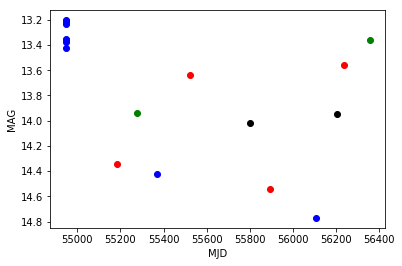

(292.2352304264401, 43.0936891516194, 'kplr2009115080620_ffi-cal.fits[46]')


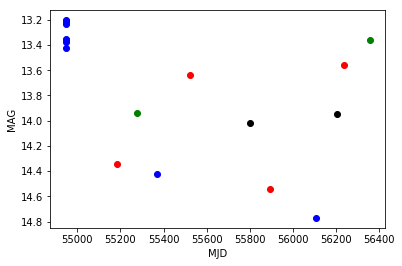

(292.23523049244886, 43.0936897017523, 'kplr2009115131122_ffi-cal.fits[46]')


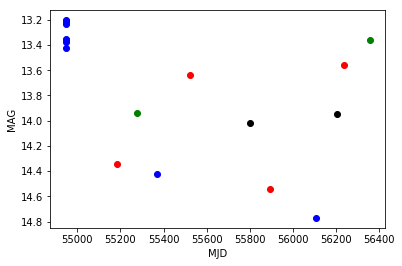

(292.2352301034367, 43.09368848492147, 'kplr2009115173611_ffi-cal.fits[46]')


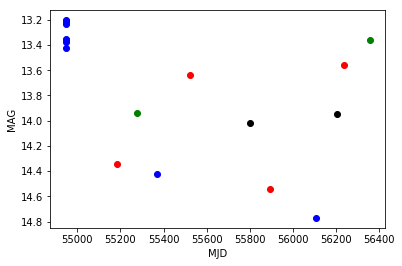

(292.23522908953754, 43.09369218659433, 'kplr2009116035924_ffi-cal.fits[46]')


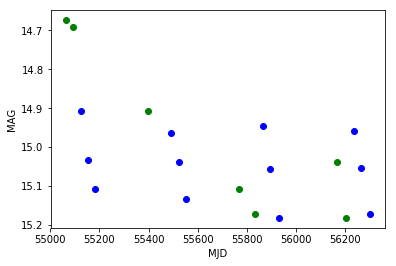

(293.13394414387665, 39.29012797973521, 'kplr2009231194831_ffi-cal.fits[5]')


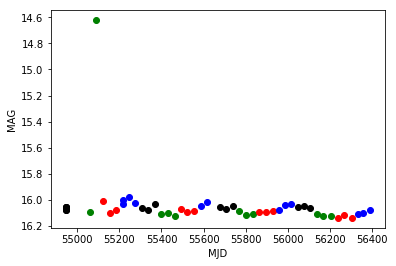

(285.7272286846728, 46.42772649282039, 'kplr2009260000800_ffi-cal.fits[57]')


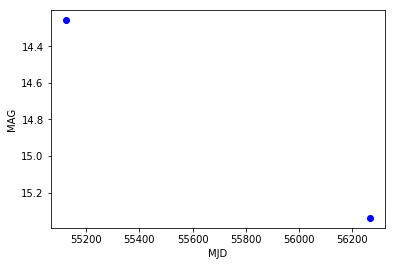

(288.1480409780076, 50.575179784264684, 'kplr2009292020429_ffi-cal.fits[31]')


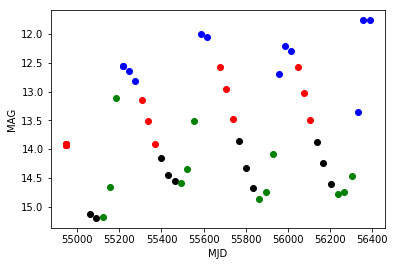

(284.20487551844514, 47.95321832161631, 'kplr2009351005245_ffi-cal.fits[69]')


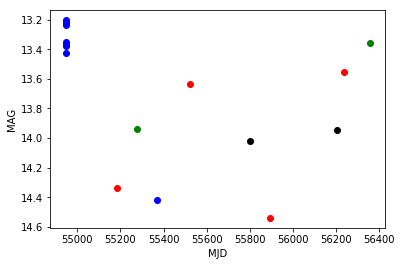

(292.23520576067165, 43.0937589591203, 'kplr2010078174524_ffi-cal.fits[62]')


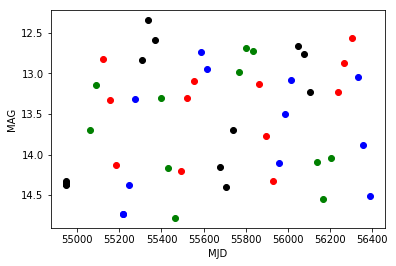

(291.4359254705428, 51.15885929182814, 'kplr2010111125026_ffi-cal.fits[53]')


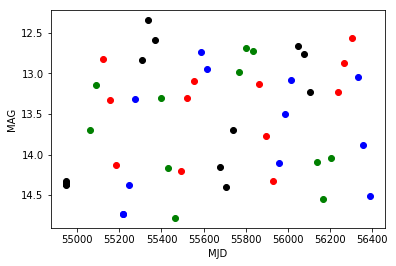

(291.43593325935973, 51.1588728232676, 'kplr2010140101631_ffi-cal.fits[53]')


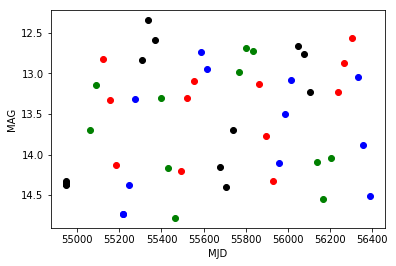

(291.43594106211066, 51.158905434676505, 'kplr2010174164113_ffi-cal.fits[53]')


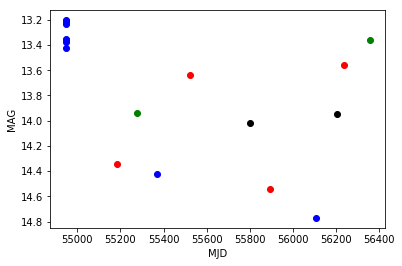

(292.23525590715076, 43.09376975642477, 'kplr2010326181728_ffi-cal.fits[38]')


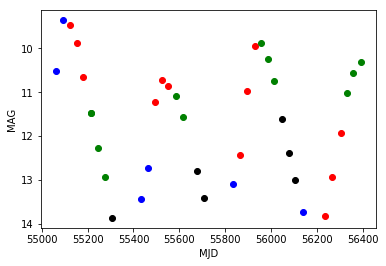

(298.33375917137886, 40.97142800044138, 'kplr2011116104002_ffi-cal.fits[71]')


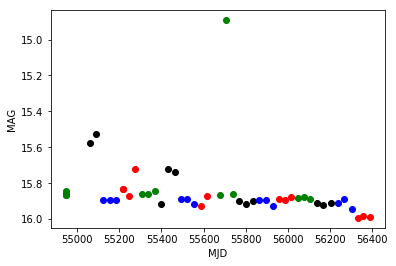

(294.6668925303648, 50.45855027469197, 'kplr2011145152723_ffi-cal.fits[74]')


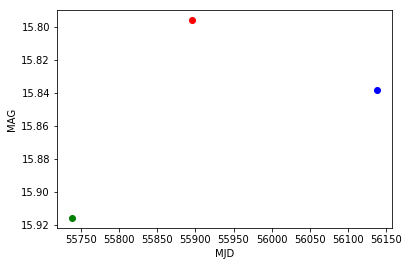

(292.20832134632974, 46.464068835819646, 'kplr2011177110110_ffi-cal.fits[62]')


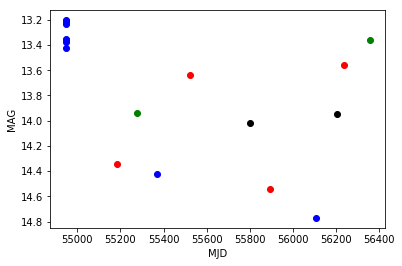

(292.23525867991003, 43.09377632603181, 'kplr2011240181752_ffi-cal.fits[22]')


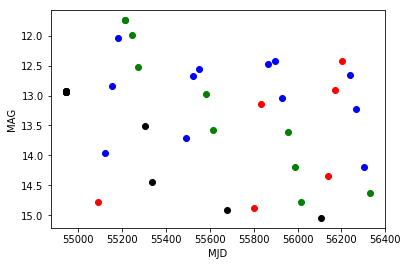

(292.3813052478641, 37.71123531004457, 'kplr2011271191331_ffi-cal.fits[3]')


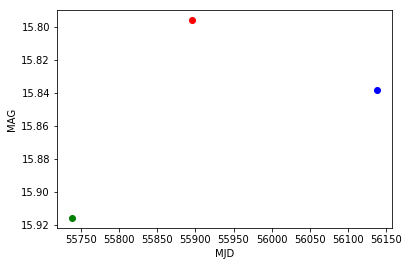

(292.20836218926235, 46.46419760319968, 'kplr2011334181008_ffi-cal.fits[22]')


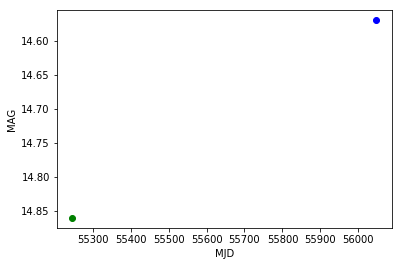

(288.4934079182069, 40.73577466652988, 'kplr2012121122500_ffi-cal.fits[25]')


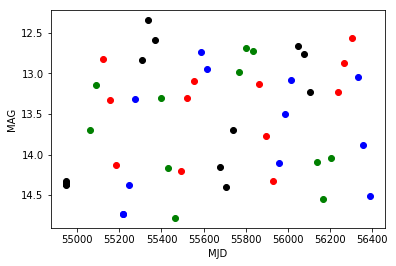

(291.43593232666944, 51.15887740349186, 'kplr2012121122500_ffi-cal.fits[53]')


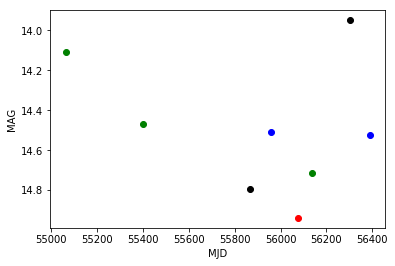

(281.16305305702406, 43.37459426241148, 'kplr2012151105138_ffi-cal.fits[4]')


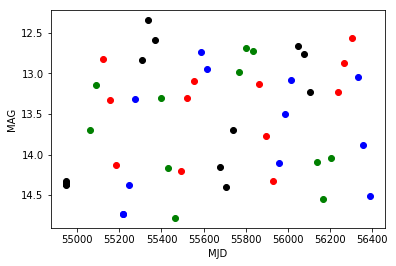

(291.4359309585661, 51.158901149659066, 'kplr2012151105138_ffi-cal.fits[53]')


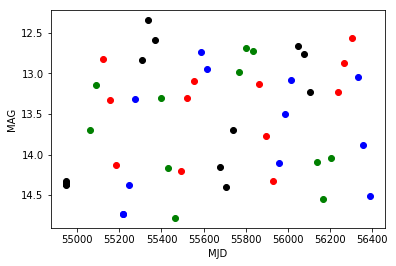

(291.43593409943276, 51.15892321087754, 'kplr2012179140901_ffi-cal.fits[53]')


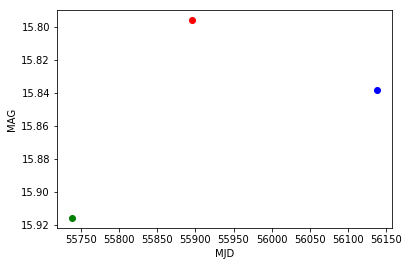

(292.2084021086923, 46.4642218707108, 'kplr2012211123923_ffi-cal.fits[46]')


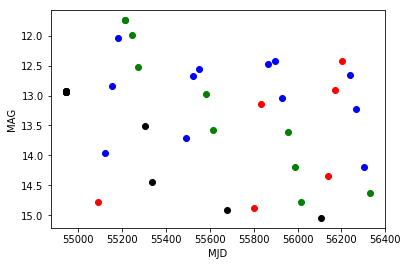

(292.3812911872557, 37.7111963697075, 'kplr2012242195726_ffi-cal.fits[3]')


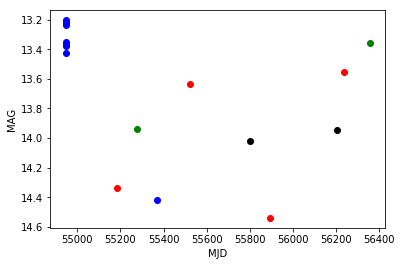

(292.23523419475157, 43.09379951828043, 'kplr2012277203051_ffi-cal.fits[22]')


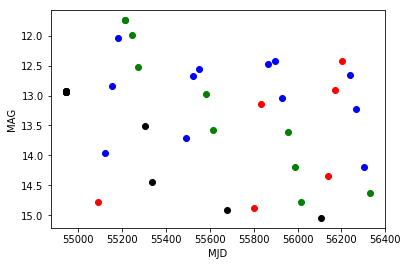

(292.38128035854936, 37.71125550421679, 'kplr2012277203051_ffi-cal.fits[3]')


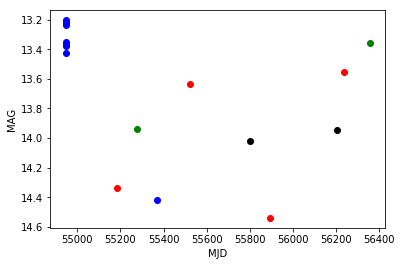

(292.23521430015495, 43.09380968431812, 'kplr2012310200152_ffi-cal.fits[38]')


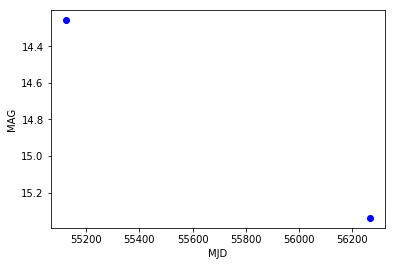

(288.14798518324847, 50.57520062753317, 'kplr2012341215621_ffi-cal.fits[31]')


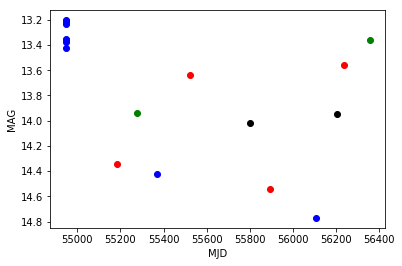

(292.2352209010263, 43.09376755458721, 'kplr2013065115251_ffi-cal.fits[62]')


In [27]:
makeLightCurves(origTab)

In [11]:
#origTab = ascii.read('/home/mj1e16/outTablesImproved/matchSNabove10.csv')

In [11]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/match1mag.csv')

In [14]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/100sn.csv')

In [15]:
origTab['OBJECT INDEX'] = range(len(origTab))

In [16]:
allTabs = []
imNames = []
mag = []
#date = []
imageReDo = []
fullExt = []
otherfullExt = []
for im in range(len(origTab)):
    ra = origTab['RA'][im]
    dec =origTab['DEC'][im]
    image = origTab['IMAGE_NAME'][im]
    indiext = getIndiExt(image,imagelist,extensionOrders)[0]
    nonindiext = getIndiExt(image,imagelist,extensionOrders)[1]
    allNames = getAllccds(imagelist,indiext,extensionOrders)
    testmatch = []
    magone = []
    imNameOne = []
    extensions = []
    for x in range(len(allNames)):
        loc1 = allNames[x].find(imageDirectory)+len(imageDirectory)
        imNameOnly = allNames[x][loc1:]
        loc2 = imNameOnly.find('[')+1
        loc3 = imNameOnly.find(']')
        imextOnly = imNameOnly[loc2:loc3]
        oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+imNameOnly+'.csv')
        oneimTab['OBJECT INDEX'] = range(len(oneimTab))
        if len(testmatch) == 0:
            try:
                testmatch = findMatchesNoCondition(oneimTab,ra,dec)
                if len(testmatch) != 0:
                    onemag = testmatch['MAG_BEST'][0]
                    magone.append(onemag)
                    imNameOne.append(imNameOnly)
                    extensions.append(imextOnly)
                    #extensionsOther.append(indiext)
                    print(imNameOnly,imextOnly)
    #                 mag.append(testmatch['MAG_BEST'][0])
                    #imNames.append(imNameOnly)
            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
        else:
            try:
                oneim = findMatchesNoCondition(oneimTab,ra,dec)

            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
            if len(oneim) != 0:
                onemag = oneim['MAG_BEST'][0]
                magone.append(onemag)
                imNameOne.append(imNameOnly)
                extensions.append(imextOnly)
                #extensionsOther.append(indiext)
                print(imNameOnly)
                #print(testmatch['IMAGE_NAME'],oneim['IMAGE_NAME'])
                testmatch = vstack([testmatch,oneim])
                
        
    fullExt.append(extensions) 
    #otherfullExt.append(extensionsOther)
    imNames.append(imNameOne)
    mag.append(magone)
    
    #allTabs.append(testmatch)
    print('index {}'.format(im),len(testmatch))

('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2011334181008_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2011116104002_ffi-cal.fits[15]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fits[71]
kplr2011208112727_ffi-cal.fits[75]
kplr200923

kplr2012242195726_ffi-cal.fits[60]
kplr2013065115251_ffi-cal.fits[28]
kplr2009115053616_ffi-cal.fits[20]
kplr2009115131122_ffi-cal.fits[20]
kplr2012032101442_ffi-cal.fits[28]
kplr2010049182302_ffi-cal.fits[28]
kplr2012060123308_ffi-cal.fits[28]
('index 5', 45)
('kplr2012121122500_ffi-cal.fits[25]', '25')
kplr2009322233047_ffi-cal.fits[57]
kplr2010111125026_ffi-cal.fits[25]
kplr2011177110110_ffi-cal.fits[25]
kplr2011271191331_ffi-cal.fits[17]
kplr2010174164113_ffi-cal.fits[25]
kplr2009114174833_ffi-cal.fits[25]
kplr2011334181008_ffi-cal.fits[57]
kplr2009114204835_ffi-cal.fits[25]
kplr2012341215621_ffi-cal.fits[57]
kplr2009115080620_ffi-cal.fits[25]
kplr2013038133130_ffi-cal.fits[65]
kplr2011116104002_ffi-cal.fits[25]
kplr2010019225502_ffi-cal.fits[65]
kplr2012310200152_ffi-cal.fits[57]
kplr2010020005046_ffi-cal.fits[65]
kplr2012179140901_ffi-cal.fits[25]
kplr2009351005245_ffi-cal.fits[57]
kplr2011208112727_ffi-cal.fits[17]
kplr2012211123923_ffi-cal.fits[17]
kplr2011053174401_ffi-cal.fit

kplr2011024134926_ffi-cal.fits[50]
Redo file kplr2012151105138_ffi-cal.fits[6]
kplr2012151105138_ffi-cal.fits[6]
kplr2009115002613_ffi-cal.fits[6]
kplr2009116035924_ffi-cal.fits[6]
kplr2009292020429_ffi-cal.fits[78]
kplr2010203012215_ffi-cal.fits[34]
kplr2012004204112_ffi-cal.fits[78]
kplr2012277203051_ffi-cal.fits[34]
kplr2010356020128_ffi-cal.fits[78]
kplr2010326181728_ffi-cal.fits[78]
kplr2012242195726_ffi-cal.fits[34]
kplr2013065115251_ffi-cal.fits[50]
kplr2012032101442_ffi-cal.fits[50]
kplr2010049182302_ffi-cal.fits[50]
kplr2012060123308_ffi-cal.fits[50]
('index 11', 47)
('kplr2012121122500_ffi-cal.fits[47]', '47')
kplr2009322233047_ffi-cal.fits[39]
kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-

kplr2010049182302_ffi-cal.fits[65]
kplr2012060123308_ffi-cal.fits[65]
('index 18', 30)
('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2009322233047_ffi-cal.fits[71]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fi

kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-cal.fits[47]
kplr2010296192119_ffi-cal.fits[39]
kplr2013038133130_ffi-cal.fits[63]
kplr2011116104002_ffi-cal.fits[47]
kplr2010140101631_ffi-cal.fits[47]
kplr2010019225502_ffi-cal.fits[63]
kplr2013098115308_ffi-cal.fits[63]
kplr2010020005046_ffi-cal.fits[63]
kplr2009351005245_ffi-cal.fits[39]
kplr2010078174524_ffi-cal.fits[63]
kplr2011053174401_ffi-cal.fits[63]
kplr2011145152723_ffi-cal.fits[47]
kplr2011024134926_ffi-cal.fits[63]
kplr2012151105138_ffi-cal.fits[47]
kplr2009115002613_ffi-cal.fits[47]
kplr2009116035924_ffi-cal.fits[47]
kplr2009292020429_ffi-cal.fits[39]
kplr2012004204112_ffi-cal.fits[39]
kplr2009115173611_ffi-cal.fits[47]
kplr2010356020128_ff

In [19]:
datesfull = []
for x in range(len(imNames)):
    #if len(imNames[x]) > 1:
    dates = []
    for y in range(len(imNames[x])):
        image = imNames[x][y]
        #print(image)
        loc1 = image.find('[')
        loc2  = image.find(']')
        imagename = imageDirectory+image[:loc1]
        #print(imagename)
        pos = image[loc1+1:loc2]
        date = findDate(imagename,pos)
        dates.append(date)
    datesfull.append(dates)

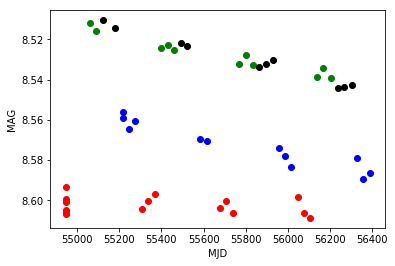

(281.06580062022897, 47.674570850003406, 'kplr2009114174833_ffi-cal.fits[15]')


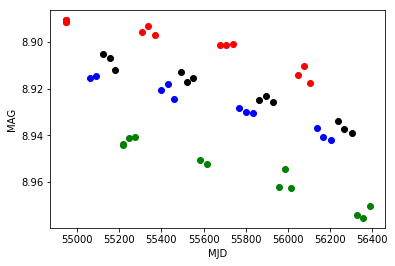

(289.86330415454705, 38.02818387052353, 'kplr2009114174833_ffi-cal.fits[29]')


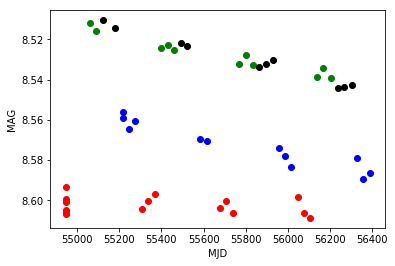

(281.0659413436924, 47.674820019383326, 'kplr2009114204835_ffi-cal.fits[15]')


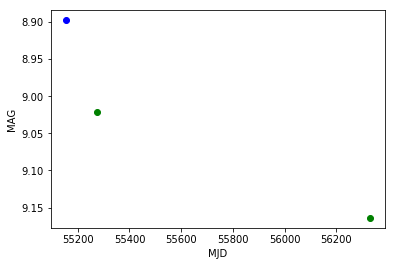

(292.5743879658267, 48.65116456063824, 'kplr2009322233047_ffi-cal.fits[25]')


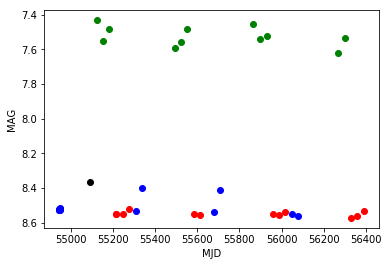

(293.2555181191914, 42.167597797237256, 'kplr2009322233047_ffi-cal.fits[39]')


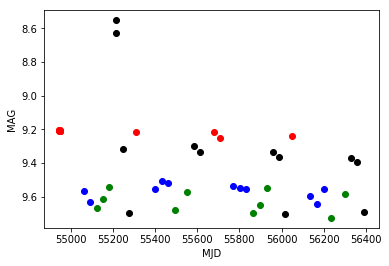

(284.4915861187469, 45.639227820339016, 'kplr2010019225502_ffi-cal.fits[28]')


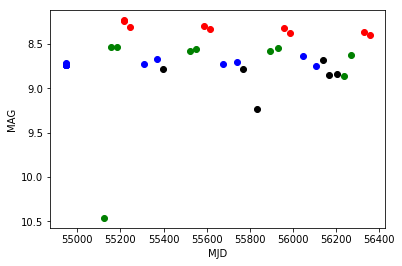

(288.44186318816713, 40.02411075963774, 'kplr2010019225502_ffi-cal.fits[65]')


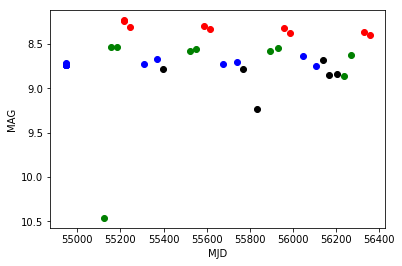

(288.44181487436686, 40.0241846061678, 'kplr2010020005046_ffi-cal.fits[65]')


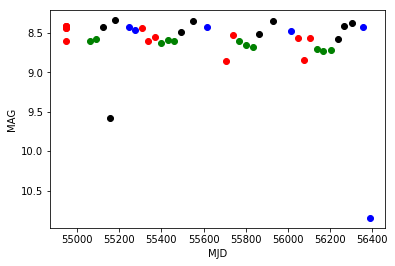

(282.03534530355205, 47.26822868719558, 'kplr2010111125026_ffi-cal.fits[15]')


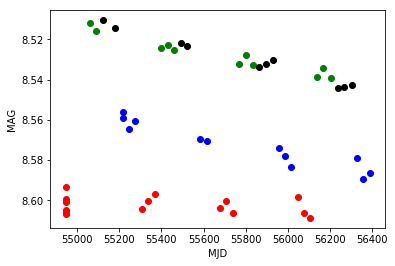

(281.0659413882968, 47.67459822763393, 'kplr2010140101631_ffi-cal.fits[15]')


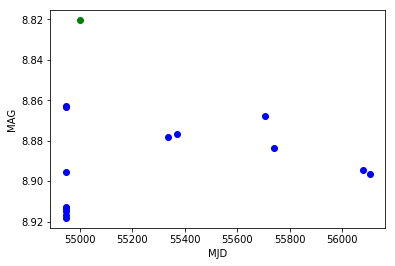

(291.8406505579973, 41.72720164556661, 'kplr2010140101631_ffi-cal.fits[45]')


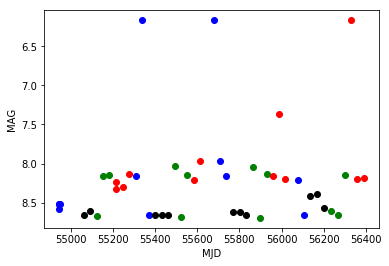

(285.0571639028919, 40.61492209666448, 'kplr2010234192745_ffi-cal.fits[34]')


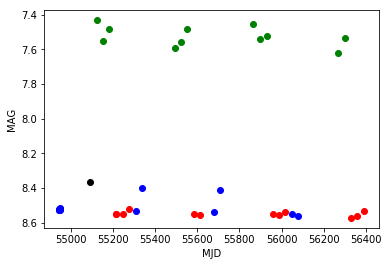

(293.2559333689719, 42.16739533280967, 'kplr2010326181728_ffi-cal.fits[39]')


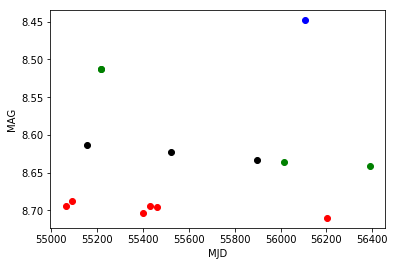

(285.91111034478854, 44.47348326142481, 'kplr2010326181728_ffi-cal.fits[66]')


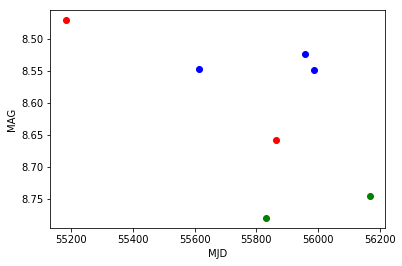

(285.3822757344309, 44.98637326566493, 'kplr2011053174401_ffi-cal.fits[26]')


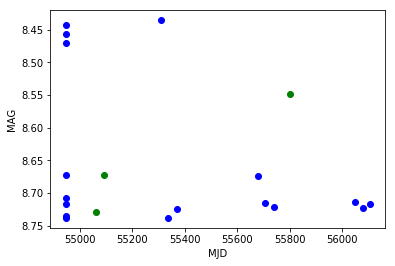

(295.30044838911095, 40.19813475404654, 'kplr2011177110110_ffi-cal.fits[50]')


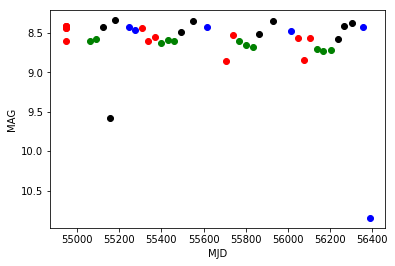

(282.0352651426848, 47.268911953801606, 'kplr2011240181752_ffi-cal.fits[75]')


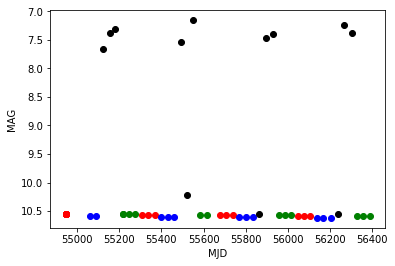

(295.04023677145346, 42.88009862622093, 'kplr2011334181008_ffi-cal.fits[17]')


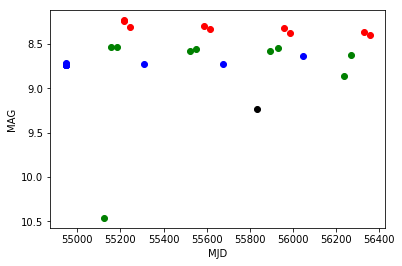

(288.44319323001105, 40.024516582336666, 'kplr2012121122500_ffi-cal.fits[25]')


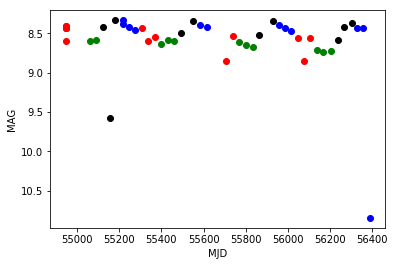

(282.0357171240712, 47.26918929870344, 'kplr2012151105138_ffi-cal.fits[15]')


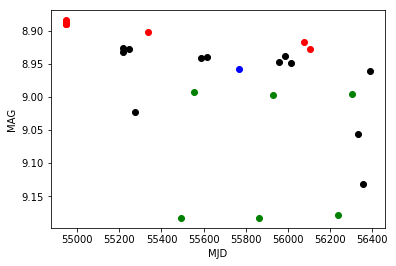

(289.65247405672727, 47.32778800607652, 'kplr2012151105138_ffi-cal.fits[37]')


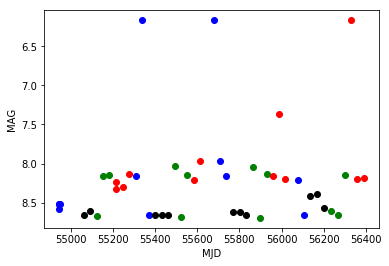

(285.05693607339543, 40.6146068424017, 'kplr2012242195726_ffi-cal.fits[34]')


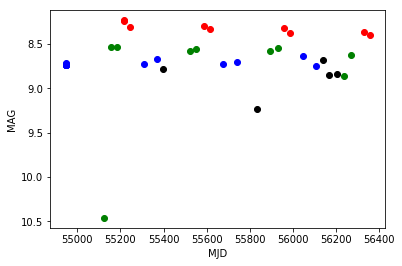

(288.4425853460137, 40.02334188034389, 'kplr2012310200152_ffi-cal.fits[57]')


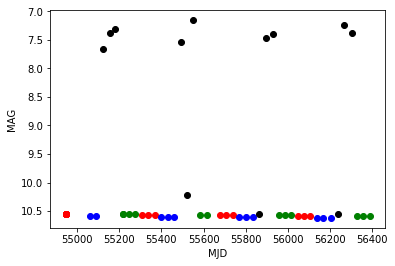

(295.0406644792216, 42.879860972498, 'kplr2012341215621_ffi-cal.fits[17]')


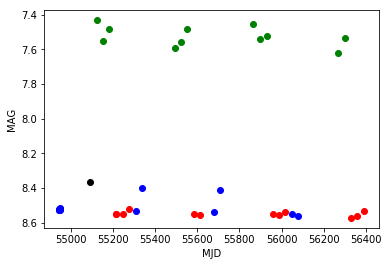

(293.25545320988607, 42.16653300167808, 'kplr2012341215621_ffi-cal.fits[39]')


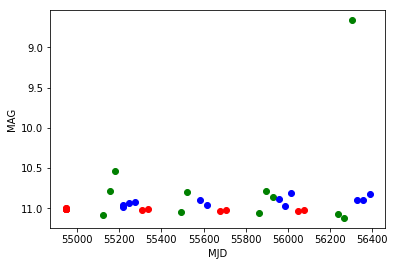

(291.5850787899832, 48.43674100940777, 'kplr2013011160902_ffi-cal.fits[27]')


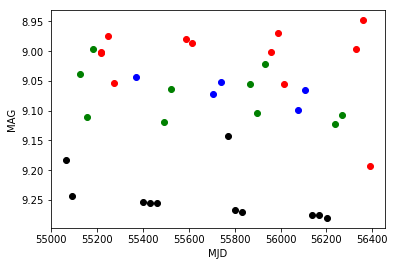

(281.5595290837081, 43.893302122615225, 'kplr2013065115251_ffi-cal.fits[29]')


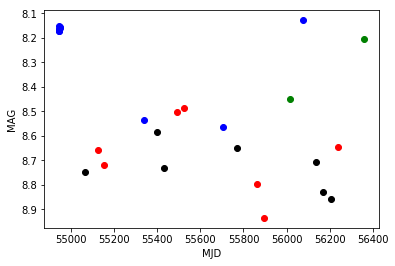

(293.62399242064873, 42.5367334023391, 'kplr2013065115251_ffi-cal.fits[62]')


In [22]:
isThereAmatch = [0 for x in mag]
colours = ['bo','go','ro','ko']
coloursAlt = ['b*','g*','r*','k*']
for x in range(len(datesfull)):
    if len(datesfull[x]) > 1:
        if isThereAmatch[x] ==0:
            for y in range(len(datesfull[x])):
                exts = list(set(fullExt[x]))
                #print(exts)
                pos = exts.index(fullExt[x][y])
                colour = colours[pos]
#                 print(pos)
#                 print(colour)
#                 print(len(datesfull[x]),len(mag[x]))
                plt.plot(datesfull[x][y],mag[x][y],colours[pos])
        else:
            for y in range(len(datesfull[x])):
                exts = list(set(fullExt[x]))
                pos = exts.index(fullExt[x][y])
                #print(exts)
                colour = colours[pos]
                plt.plot(datesfull[x][y],mag[x][y],coloursAlt[pos])
                
        plt.ylabel('MAG')
        plt.xlabel('MJD')
        plt.gca().invert_yaxis()
        #plt.legend()
        plt.show()
        print(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x])

In [22]:
df = origTab.to_pandas()
df2 = df[df['RA'] == 285.72720076444773]
df2

,NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,magDiff,MAG_BEST_ORIG,S/N,OBJECT INDEX
188,7,9528.476,26.68024,15.0524,481.5612,77.4627,0.298,285.727201,46.427704,kplr2009260000800_ffi-cal.fits[57],meidian_25_57.fits,diff_imNo14_channel25_ccd57.fits,35217,-1.215422,14.6233,77.63661,188


In [162]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,xcoords,ycoords):
#     for tables in range(len(sexTabList)):
#         if tabType == 'dao':
#             xcoords = sexTabList[tables]['xcentroid']
#             ycoords = sexTabList[tables]['ycentroid']
#         elif tabType == 'sex':
#             xcoords = sexTabList[tables]['X_IMAGE']
#             ycoords = sexTabList[tables]['Y_IMAGE']
#         elif tabType == 'iraf':
#             xcoords = sexTabList[tables]['X_POS']
#             ycoords = sexTabList[tables]['Y_POS']        
#         else:
#             print('tab type error')
#             break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [161]:
ra = [origTab[]]
makeDS9RegFile(origTab,'/home/mj1e16/outTablesImproved/region','sex')
imagename = imageDirectory+origTab['IMAGE_NAME'][x]
subprocess.call(['ds9',imagename,'-r','/home/mj1e16/outTablesImproved/region.reg'])
#origTab['IMAGE_NAME']

TypeError: object of type 'numpy.float64' has no len()

In [147]:
for x in range(len(imNames)):
    if len(imNames[x]) > 1:
        dates = []
        for y in range(len(imNames[x])):
            image = imNames[x][y]
            #print(image)
            loc1 = image.find('[')
            loc2  = image.find(']')
            imagename = imageDirectory+image[:loc1]
            #print(imagename)
            pos = image[loc1+1:loc2]
            date = findDate(imagename,pos)
            dates.append(date)
        
        plt.plot(dates,mag[x],'o',label=str(x))
        plt.ylabel('MAG')
        plt.xlabel('MJD')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [139]:
mag

[[15.7447],
 [16.2535],
 [15.9918],
 [10.4432, 10.4422, 10.4492, 10.4557, 10.4668],
 [12.5416,
  12.512,
  12.4601,
  12.4621,
  12.4663,
  12.5091,
  12.5084,
  12.4375,
  12.5062,
  12.5132,
  12.5099,
  12.5104,
  12.5151,
  12.539,
  12.5148,
  12.4673,
  12.4665,
  12.4671,
  12.47,
  12.4669,
  12.5197,
  12.5175,
  12.5167,
  12.5425,
  12.5419,
  12.5368,
  12.4758,
  12.4738,
  12.4432,
  12.4807,
  12.4806,
  12.4802,
  12.5285,
  12.5273,
  12.5462,
  12.5245,
  12.5448,
  12.4824,
  12.4823,
  12.4526,
  12.4906,
  12.4905,
  12.4893],
 [11.9721,
  11.9715,
  11.9721,
  11.9385,
  11.9492,
  11.9364,
  11.9475,
  11.9484,
  12.0273,
  12.0142,
  12.0176,
  12.0229,
  12.0213,
  12.0035,
  12.0038,
  12.0061,
  12.0068,
  12.0068,
  12.0068,
  12.0068,
  12.032,
  12.0073,
  12.0333,
  12.0226,
  12.0267,
  12.0258,
  12.0053,
  12.0071,
  12.0071,
  12.0071,
  12.0071,
  12.0367,
  12.0375,
  12.0359,
  12.0296,
  12.0347,
  12.0477,
  12.0094,
  12.0114,
  12.0153,
  12.01

In [104]:
allTabs[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [100]:
testmatch

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [72]:
image = origTab['IMAGE_NAME'][0]
print(image)
loc1 = image.find('[')
loc2  = image.find(']')
print(loc1,loc2)
imagename = image[:loc1]
pos = image[loc1+1:loc2]
print(imagename,pos)

kplr2009114174833_ffi-cal.fits[58]
(30, 33)
('kplr2009114174833_ffi-cal.fits', '58')


In [65]:
subprocess.call(['ds9',imagelist[0]+'[{}]'.format(int(extensionOrders[0][1]))])

0

In [97]:
origTab

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,diffImage,medianImage,magDiff,MAG_BEST_ORIG,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64,str32,str18,float64,float64,int64
1,4972.103,37.4395,15.7586,429.9972,24.7407,0.351,291.9081476036849,47.058497168533194,kplr2009114174833_ffi-cal.fits[58],meidian_18_58.fits,diff_imNo11_channel18_ccd58.fits,122511,diff_imNo11_channel18_ccd58.fits,meidian_18_58.fits,-4.733674110651155,15.7447,0
159,2963.834,14.20312,16.3204,618.8993,260.8472,0.059,282.2997286819453,48.51511298543987,kplr2009115131122_ffi-cal.fits[16],meidian_12_16.fits,diff_imNo49_channel12_ccd16.fits,199471,diff_imNo49_channel12_ccd16.fits,meidian_12_16.fits,-3.0588167843178122,16.2535,1
31,2797.135,14.15697,16.3832,127.6044,916.9813,0.044,286.17639521590405,44.443401074095455,kplr2009115131122_ffi-cal.fits[18],meidian_26_18.fits,diff_imNo49_channel26_ccd18.fits,26660,diff_imNo49_channel26_ccd18.fits,meidian_26_18.fits,-4.250811469125403,16.3614,2
12,2862.116,37.76081,16.3583,1039.0616,993.9548,0.413,282.51787304188844,47.587614950317615,kplr2009260000800_ffi-cal.fits[76],meidian_12_76.fits,diff_imNo14_channel12_ccd76.fits,37135,diff_imNo14_channel12_ccd76.fits,meidian_12_76.fits,-4.9381187120948,16.3467,3
68,3784.545,39.92257,16.055,341.8187,226.6804,0.071,286.16801092086166,37.67179113909842,kplr2009351005245_ffi-cal.fits[75],meidian_71_75.fits,diff_imNo28_channel71_ccd75.fits,240247,diff_imNo28_channel71_ccd75.fits,meidian_71_75.fits,-3.5398002117672567,16.0125,4
118,3451.97,23.67002,16.1548,947.2881,593.7286,0.048,284.7198297858132,41.675149597439834,kplr2010020005046_ffi-cal.fits[49],meidian_49_49.fits,diff_imNo25_channel49_ccd49.fits,125109,diff_imNo25_channel49_ccd49.fits,meidian_49_49.fits,-5.09291635990458,16.1448,5
158,3651.136,36.02952,16.0939,645.012,273.612,0.114,294.896920769719,49.00664051747236,kplr2010078174524_ffi-cal.fits[13],meidian_13_13.fits,diff_imNo31_channel13_ccd13.fits,46525,diff_imNo31_channel13_ccd13.fits,meidian_13_13.fits,-4.209689270551595,16.0712,6
42,4922.818,28.08094,15.7695,847.0221,792.5739,0.006,283.1588141524291,47.39383732680302,kplr2010078174524_ffi-cal.fits[9],meidian_9_9.fits,diff_imNo31_channel9_ccd9.fits,152817,diff_imNo31_channel9_ccd9.fits,meidian_9_9.fits,-4.343615660343915,15.7494,7
5,1774.637,20.95655,16.8772,555.793,52.6379,0.11,282.85892686984414,46.1930525322328,kplr2010140101631_ffi-cal.fits[14],meidian_10_14.fits,diff_imNo21_channel10_ccd14.fits,259586,diff_imNo21_channel10_ccd14.fits,meidian_10_14.fits,-3.1725772265789005,16.8172,8


In [2]:
import os

In [8]:
a = os.listdir('/data/mj1e16/kepler/cal/')

In [6]:
a = [x for x in a if x == 'kplr2012121122500_ffi-cal.fits']

In [9]:
a.index('kplr2012121122500_ffi-cal.fits')

0

In [11]:
np.log10(5)

0.6989700043360189